# Data preprocessing

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 8.9 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from torch import nn
import matplotlib.pyplot as plt

from functools import partial
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from random import randint
import torchmetrics
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Diploma/book_crossing/"

In [ ]:
book_ratings = pd.read_table(path + 'book_ratings.dat', sep="\t", header=0)
book_ratings['time'] = book_ratings.index
book_ratings

,user_id,book_id,rating,time
0,1,6264,7.0,0
1,1,4350,7.0,1
2,1,6252,5.0,2
3,1,202,9.0,3
4,1,6266,6.0,4
...,...,...,...,...
62651,2945,15719,8.0,62651
62652,2945,11960,6.0,62652
62653,2945,8515,9.0,62653
62654,2945,9417,7.0,62654


In [ ]:
users_info = pd.read_table(path + 'users_info.dat', sep="\t", header=0, index_col=False)
items_info = pd.read_table(path + 'items_info.dat', sep="\t", header=0, index_col=False)
ratings_df = pd.merge(book_ratings, items_info)[['user_id', 'book_id', 'Book_title', 'Book_Author', 'time', 'rating', 'Year-Of-Publication']]
ratings_df["user_id"] = ratings_df["user_id"].astype(str)

In [ ]:
users_info

,user_id,Location,Age
0,1,"minneapolis, minnesota, usa",24
1,2,"san diego, california, usa",20
2,3,"novinger, missouri, usa",16
3,4,"sonoma, california, usa",34
4,5,"berkeley, california, usa",23
...,...,...,...
2941,2942,"east orange, new jersey, usa",56
2942,2943,"san antonio, texas, usa",27
2943,2944,"storm lake, iowa, usa",48
2944,2945,"lake george, new york, usa",34


In [ ]:
items_info

,book_id,ISBN,Book_title,Book_Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
1,2,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
2,3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...
3,4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...
4,5,0609804618,Our Dumb Century: The Onion Presents 100 Years...,The Onion,1999,Three Rivers Press,http://images.amazon.com/images/P/0609804618.0...,http://images.amazon.com/images/P/0609804618.0...,http://images.amazon.com/images/P/0609804618.0...
...,...,...,...,...,...,...,...,...,...
17379,17380,0449209202,Guide to Confident Living,Norman Vincent Peale,1985,Fawcett Books,http://images.amazon.com/images/P/0449209202.0...,http://images.amazon.com/images/P/0449209202.0...,http://images.amazon.com/images/P/0449209202.0...
17380,17381,2209014026,Ludwig Feuerbach,F. Engels,1976,La Dispute,http://images.amazon.com/images/P/2209014026.0...,http://images.amazon.com/images/P/2209014026.0...,http://images.amazon.com/images/P/2209014026.0...
17381,17382,070892722X,To Bring You Joy (Ulverscroft Large Print Series),Essie Summers,1992,Ulverscroft Large Print,http://images.amazon.com/images/P/070892722X.0...,http://images.amazon.com/images/P/070892722X.0...,http://images.amazon.com/images/P/070892722X.0...
17382,17383,1570031843,Like Unto Like: A Novel (Southern Classics Ser...,Katherine Sherwood Bonner McDowell,1997,University of South Carolina Press,http://images.amazon.com/images/P/1570031843.0...,http://images.amazon.com/images/P/1570031843.0...,http://images.amazon.com/images/P/1570031843.0...


In [ ]:
def get_last_n_ratings_by_user(
    df, n, min_ratings_per_user=1, user_colname="user_id", timestamp_colname="time"
):
    return (
        df.groupby(user_colname)
        .filter(lambda x: len(x) >= min_ratings_per_user)
        .sort_values(timestamp_colname)
        .groupby(user_colname)
        .tail(n)
        .sort_values(user_colname)
    )

def mark_last_n_ratings_as_validation_set(
    df, n, min_ratings=1, user_colname="user_id", timestamp_colname="time"
  ):
    df["is_valid"] = False
    df.loc[
        get_last_n_ratings_by_user(
            df,
            n,
            min_ratings,
            user_colname=user_colname,
            timestamp_colname=timestamp_colname,
        ).index,
        "is_valid",
    ] = True
    return df

In [ ]:
mark_last_n_ratings_as_validation_set(ratings_df, 1)

,user_id,book_id,Book_title,Book_Author,time,rating,Year-Of-Publication,is_valid
0,1,6264,Something Wicked This Way Comes,Ray Bradbury,0,7.0,1983,False
1,496,6264,Something Wicked This Way Comes,Ray Bradbury,10090,8.0,1983,False
2,676,6264,Something Wicked This Way Comes,Ray Bradbury,14043,10.0,1983,False
3,1842,6264,Something Wicked This Way Comes,Ray Bradbury,39880,10.0,1983,False
4,1,4350,The Mists of Avalon,MARION ZIMMER BRADLEY,1,7.0,2000,False
...,...,...,...,...,...,...,...,...
62651,2945,16981,"Jessi Ramsey, Pet Sitter (Baby-Sitters Club (P...",Ann M. Martin,62642,7.0,1989,False
62652,2945,14501,STAY AWAY FROM THE TREEHOUSE (GHOSTS OF FEAR S...,R.L. Stine,62643,7.0,1996,False
62653,2945,3490,Bright Eyes (Coulter Family Series),Catherine Anderson,62649,8.0,2004,False
62654,2945,15719,Arcadia,Jim Crace,62651,8.0,1997,False


In [ ]:
grouped_ratings = ratings_df.sort_values(by='time').groupby('user_id').agg(tuple).reset_index()
grouped_ratings

,user_id,book_id,Book_title,Book_Author,time,rating,Year-Of-Publication,is_valid
0,1,"(6264, 4350, 6252, 202, 6266, 4810, 6251, 160,...","(Something Wicked This Way Comes, The Mists of...","(Ray Bradbury, MARION ZIMMER BRADLEY, Nora Rob...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(7.0, 7.0, 5.0, 9.0, 6.0, 5.0, 9.0, 9.0, 8.0, ...","(1983, 2000, 1990, 1995, 1992, 2002, 1997, 200...","(False, False, False, False, False, False, Fal..."
1,1002,"(6952, 1289, 1290, 629, 628, 13337, 13972, 186...",(Bride of Dark and Stormy: Yet More of the Bes...,"(Scott Rice, Anne Rice, James Herriot, H. P. L...","(20860, 20861, 20862, 20863, 20864, 20865, 208...","(8.0, 8.0, 7.0, 6.0, 6.0, 5.0, 4.0, 8.0, 7.0, ...","(1988, 1993, 1982, 2003, 1992, 1999, 1989, 199...","(False, False, False, False, False, False, Fal..."
2,1003,"(1397, 1383, 14648, 1384, 13559, 11599, 3561, ...","(Must Be Magic, On a Wicked Dawn (Cynster Nove...","(Patricia Rice, Stephanie Laurens, Peter Colli...","(20882, 20883, 20884, 20885, 20886, 20887, 208...","(8.0, 9.0, 8.0, 8.0, 8.0, 10.0, 8.0, 9.0, 9.0,...","(2002, 2002, 2002, 2003, 1995, 1975, 2002, 200...","(False, False, False, False, False, False, Fal..."
3,1004,"(297, 44, 1342, 16634, 5172, 1587, 93, 4588, 1...","(Rules of the Wild, El Senor De Los Anillos: L...","(Francesca Marciano, J. R. R. Tolkien, Terry B...","(21974, 21975, 21976, 21977, 21978, 21979, 219...","(6.0, 7.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,...","(1998, 2001, 1990, 1995, 2001, 1977, 2002, 200...","(False, False, False, False, False, False, Fal..."
4,1005,"(10309, 10903, 35, 7547, 3703, 2143, 3408, 129...",(Wanted: An Interesting Life (Harlequin Flipsi...,"(Bev Katz Rosenbaum, Chuck Logan, Benjamin Hof...","(22006, 22007, 22008, 22009, 22010, 22011, 220...","(7.0, 8.0, 6.0, 8.0, 8.0, 10.0, 8.0, 8.0, 9.0,...","(2004, 1999, 1983, 2004, 1989, 1988, 2001, 199...","(False, False, False, False, False, False, Fal..."
...,...,...,...,...,...,...,...,...
1290,99,"(2304, 1092, 4975, 4973, 1099, 4970, 281, 1155...","(The End of the Pier, The Unknown Errors of Ou...","(Martha Grimes, Chitra Banerjee Divakaruni, LA...","(1903, 1904, 1905, 1906, 1907, 1908, 1909, 191...","(8.0, 8.0, 9.0, 5.0, 6.0, 7.0, 9.0, 7.0, 8.0, ...","(1992, 2002, 2003, 2003, 1990, 1937, 1997, 200...","(False, False, False, False, False, False, Fal..."
1291,990,"(16053, 2655, 15447, 5921, 1540, 4441, 3684, 1...","(The Anatomist, La caverna = A caverna, Solitu...","(Federico Andahazi, Jose Saramago, Anthony Sto...","(20721, 20722, 20723, 20724, 20725, 20726, 207...","(9.0, 6.0, 7.0, 10.0, 10.0, 10.0, 10.0, 10.0, ...","(1999, 2002, 1988, 2002, 1990, 1994, 1990, 199...","(False, False, False, False, False, False, Fal..."
1292,991,"(105, 6191, 8745, 8779, 4461, 5720, 8145, 741,...",(The James Dean Affair: A Neil Gulliver Stevie...,"(Robert S. Levinson, TIMOTHY ZAHN, Alan Casty,...","(20742, 20743, 20744, 20745, 20746, 20747, 207...","(10.0, 5.0, 10.0, 8.0, 8.0, 8.0, 8.0, 9.0, 8.0...","(2000, 2004, 1975, 2001, 1993, 0, 1999, 2000, ...","(False, False, False, False, False, False, Fal..."
1293,995,"(5501, 5438, 7141, 377, 9225, 2319, 5777, 2225...","(Man In Full, Mr. Maybe, The Last Report on th...","(Tom Wolfe, Jane Green, Louise Erdrich, Spence...","(20769, 20770, 20771, 20772, 20773, 20774, 207...","(10.0, 5.0, 5.0, 7.0, 8.0, 6.0, 8.0, 8.0, 7.0,...","(0, 2002, 2002, 1998, 1988, 2001, 2003, 2001, ...","(False, False, False, False, False, False, Fal..."


In [ ]:
grouped_ratings['num_ratings'] = grouped_ratings['rating'].apply(lambda row: len(row))
grouped_ratings

,user_id,book_id,Book_title,Book_Author,time,rating,Year-Of-Publication,is_valid,num_ratings
0,1,"(6264, 4350, 6252, 202, 6266, 4810, 6251, 160,...","(Something Wicked This Way Comes, The Mists of...","(Ray Bradbury, MARION ZIMMER BRADLEY, Nora Rob...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(7.0, 7.0, 5.0, 9.0, 6.0, 5.0, 9.0, 9.0, 8.0, ...","(1983, 2000, 1990, 1995, 1992, 2002, 1997, 200...","(False, False, False, False, False, False, Fal...",32
1,1002,"(6952, 1289, 1290, 629, 628, 13337, 13972, 186...",(Bride of Dark and Stormy: Yet More of the Bes...,"(Scott Rice, Anne Rice, James Herriot, H. P. L...","(20860, 20861, 20862, 20863, 20864, 20865, 208...","(8.0, 8.0, 7.0, 6.0, 6.0, 5.0, 4.0, 8.0, 7.0, ...","(1988, 1993, 1982, 2003, 1992, 1999, 1989, 199...","(False, False, False, False, False, False, Fal...",22
2,1003,"(1397, 1383, 14648, 1384, 13559, 11599, 3561, ...","(Must Be Magic, On a Wicked Dawn (Cynster Nove...","(Patricia Rice, Stephanie Laurens, Peter Colli...","(20882, 20883, 20884, 20885, 20886, 20887, 208...","(8.0, 9.0, 8.0, 8.0, 8.0, 10.0, 8.0, 9.0, 9.0,...","(2002, 2002, 2002, 2003, 1995, 1975, 2002, 200...","(False, False, False, False, False, False, Fal...",1092
3,1004,"(297, 44, 1342, 16634, 5172, 1587, 93, 4588, 1...","(Rules of the Wild, El Senor De Los Anillos: L...","(Francesca Marciano, J. R. R. Tolkien, Terry B...","(21974, 21975, 21976, 21977, 21978, 21979, 219...","(6.0, 7.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,...","(1998, 2001, 1990, 1995, 2001, 1977, 2002, 200...","(False, False, False, False, False, False, Fal...",32
4,1005,"(10309, 10903, 35, 7547, 3703, 2143, 3408, 129...",(Wanted: An Interesting Life (Harlequin Flipsi...,"(Bev Katz Rosenbaum, Chuck Logan, Benjamin Hof...","(22006, 22007, 22008, 22009, 22010, 22011, 220...","(7.0, 8.0, 6.0, 8.0, 8.0, 10.0, 8.0, 8.0, 9.0,...","(2004, 1999, 1983, 2004, 1989, 1988, 2001, 199...","(False, False, False, False, False, False, Fal...",50
...,...,...,...,...,...,...,...,...,...
1290,99,"(2304, 1092, 4975, 4973, 1099, 4970, 281, 1155...","(The End of the Pier, The Unknown Errors of Ou...","(Martha Grimes, Chitra Banerjee Divakaruni, LA...","(1903, 1904, 1905, 1906, 1907, 1908, 1909, 191...","(8.0, 8.0, 9.0, 5.0, 6.0, 7.0, 9.0, 7.0, 8.0, ...","(1992, 2002, 2003, 2003, 1990, 1937, 1997, 200...","(False, False, False, False, False, False, Fal...",71
1291,990,"(16053, 2655, 15447, 5921, 1540, 4441, 3684, 1...","(The Anatomist, La caverna = A caverna, Solitu...","(Federico Andahazi, Jose Saramago, Anthony Sto...","(20721, 20722, 20723, 20724, 20725, 20726, 207...","(9.0, 6.0, 7.0, 10.0, 10.0, 10.0, 10.0, 10.0, ...","(1999, 2002, 1988, 2002, 1990, 1994, 1990, 199...","(False, False, False, False, False, False, Fal...",21
1292,991,"(105, 6191, 8745, 8779, 4461, 5720, 8145, 741,...",(The James Dean Affair: A Neil Gulliver Stevie...,"(Robert S. Levinson, TIMOTHY ZAHN, Alan Casty,...","(20742, 20743, 20744, 20745, 20746, 20747, 207...","(10.0, 5.0, 10.0, 8.0, 8.0, 8.0, 8.0, 9.0, 8.0...","(2000, 2004, 1975, 2001, 1993, 0, 1999, 2000, ...","(False, False, False, False, False, False, Fal...",27
1293,995,"(5501, 5438, 7141, 377, 9225, 2319, 5777, 2225...","(Man In Full, Mr. Maybe, The Last Report on th...","(Tom Wolfe, Jane Green, Louise Erdrich, Spence...","(20769, 20770, 20771, 20772, 20773, 20774, 207...","(10.0, 5.0, 5.0, 7.0, 8.0, 6.0, 8.0, 8.0, 7.0,...","(0, 2002, 2002, 1998, 1988, 2001, 2003, 2001, ...","(False, False, False, False, False, False, Fal...",59


In [ ]:
items_info['Year-Of-Publication'].unique()

array([1991, 1999, 2000, 1994, 2001, 2003, 1997, 1996, 1998, 1988, 2002,
       1993, 1982, 1992, 1995, 1980, 1983, 1952, 1987, 2004, 1986, 1984,
          0, 1981, 1968, 1961, 1958, 1990, 1985, 1974, 1976, 1989, 1977,
       1978, 1971, 1973, 1960, 1975, 1962, 1979, 1972, 1956, 1970, 1953,
       1942, 1963, 1965, 1969, 1954, 1950, 1966, 1957, 1964, 1955, 1920,
       1946, 1937, 1925, 1967, 1948, 1951, 1959, 1938, 2005, 1940, 1928,
       1927, 2050, 1923])

In [ ]:
def create_sequences(values, sequence_length):
    sequences = []
    for i, v in enumerate(values):
        seq = values[:i+1]
        if len(seq) > sequence_length:
            seq = seq[i-sequence_length+1:i+1]
        elif len(seq) < sequence_length:
            seq =(*(['[PAD]'] * (sequence_length - len(seq))), *seq)
       
        sequences.append(seq)
    return sequences

In [ ]:
sequence_length = 10
grouped_cols = ['Book_title', 'Book_Author', 'rating', 'time', 'is_valid', 'Year-Of-Publication'] 
for col in grouped_cols:
    grouped_ratings[col] = grouped_ratings[col].apply(lambda x: create_sequences(x, sequence_length))
grouped_ratings.head()

,user_id,book_id,Book_title,Book_Author,time,rating,Year-Of-Publication,is_valid,num_ratings
0,1,"(6264, 4350, 6252, 202, 6266, 4810, 6251, 160,...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...",32
1,1002,"(6952, 1289, 1290, 629, 628, 13337, 13972, 186...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...",22
2,1003,"(1397, 1383, 14648, 1384, 13559, 11599, 3561, ...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...",1092
3,1004,"(297, 44, 1342, 16634, 5172, 1587, 93, 4588, 1...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...",32
4,1005,"(10309, 10903, 35, 7547, 3703, 2143, 3408, 129...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...",50


In [ ]:
exploded_ratings = grouped_ratings[['user_id', 'Book_title']].explode('Book_title', ignore_index=True)
dfs = [grouped_ratings[[col]].explode(col, ignore_index=True) for col in grouped_cols[1:]]
seq_df = pd.concat([exploded_ratings, *dfs], axis=1)

In [ ]:
def get_last_entry(sequence):
    return sequence[-1]
seq_df['is_valid'] = seq_df['is_valid'].apply(get_last_entry)
seq_df

,user_id,Book_title,Book_Author,rating,time,is_valid,Year-Of-Publication
0,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA..."
1,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA..."
2,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA..."
3,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Som...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Ray...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 7.0...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 0, ...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 198..."
4,1,"([PAD], [PAD], [PAD], [PAD], [PAD], Something ...","([PAD], [PAD], [PAD], [PAD], [PAD], Ray Bradbu...","([PAD], [PAD], [PAD], [PAD], [PAD], 7.0, 7.0, ...","([PAD], [PAD], [PAD], [PAD], [PAD], 0, 1, 2, 3...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], 1983, 2000..."
...,...,...,...,...,...,...,...
62651,999,"(Out of Africa and, Shadows on the grass, The ...","(Isak Dinesen, Adam Davies, Zora Neale Hurston...","(10.0, 10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0,...","(20846, 20847, 20848, 20849, 20850, 20851, 208...",False,"(1985, 2002, 1978, 1999, 1993, 1994, 1999, 200..."
62652,999,"(The Frog King: A Love Story, Their eyes were ...","(Adam Davies, Zora Neale Hurston, Jill Churchi...","(10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0,...","(20847, 20848, 20849, 20850, 20851, 20852, 208...",False,"(2002, 1978, 1999, 1993, 1994, 1999, 2002, 199..."
62653,999,"(Their eyes were watching God: A novel, The Me...","(Zora Neale Hurston, Jill Churchill, H. Jackso...","(8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, ...","(20848, 20849, 20850, 20851, 20852, 20853, 208...",False,"(1978, 1999, 1993, 1994, 1999, 2002, 1995, 198..."
62654,999,(The Merchant of Menace (Jane Jeffry Mysteries...,"(Jill Churchill, H. Jackson Brown, Jane Austen...","(10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, 8.0, ...","(20849, 20850, 20851, 20852, 20853, 20854, 208...",False,"(1999, 1993, 1994, 1999, 2002, 1995, 1984, 199..."


In [ ]:
seq_df['target_rating'] = seq_df['rating'].apply(get_last_entry)
seq_df['previous_ratings'] = seq_df['rating'].apply(lambda seq: seq[:-1])
seq_df.drop(columns=['rating'], inplace=True)
seq_df

,user_id,Book_title,Book_Author,time,is_valid,Year-Of-Publication,target_rating,previous_ratings
0,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",7.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA..."
1,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",7.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA..."
2,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",5.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA..."
3,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Som...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Ray...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 0, ...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 198...",9.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 7.0..."
4,1,"([PAD], [PAD], [PAD], [PAD], [PAD], Something ...","([PAD], [PAD], [PAD], [PAD], [PAD], Ray Bradbu...","([PAD], [PAD], [PAD], [PAD], [PAD], 0, 1, 2, 3...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], 1983, 2000...",6.0,"([PAD], [PAD], [PAD], [PAD], [PAD], 7.0, 7.0, ..."
...,...,...,...,...,...,...,...,...
62651,999,"(Out of Africa and, Shadows on the grass, The ...","(Isak Dinesen, Adam Davies, Zora Neale Hurston...","(20846, 20847, 20848, 20849, 20850, 20851, 208...",False,"(1985, 2002, 1978, 1999, 1993, 1994, 1999, 200...",8.0,"(10.0, 10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0,..."
62652,999,"(The Frog King: A Love Story, Their eyes were ...","(Adam Davies, Zora Neale Hurston, Jill Churchi...","(20847, 20848, 20849, 20850, 20851, 20852, 208...",False,"(2002, 1978, 1999, 1993, 1994, 1999, 2002, 199...",8.0,"(10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0,..."
62653,999,"(Their eyes were watching God: A novel, The Me...","(Zora Neale Hurston, Jill Churchill, H. Jackso...","(20848, 20849, 20850, 20851, 20852, 20853, 208...",False,"(1978, 1999, 1993, 1994, 1999, 2002, 1995, 198...",10.0,"(8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, ..."
62654,999,(The Merchant of Menace (Jane Jeffry Mysteries...,"(Jill Churchill, H. Jackson Brown, Jane Austen...","(20849, 20850, 20851, 20852, 20853, 20854, 208...",False,"(1999, 1993, 1994, 1999, 2002, 1995, 1984, 199...",10.0,"(10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, 8.0, ..."


In [ ]:
seq_df['pad_mask'] = seq_df['Book_title'].apply(lambda x: (np.array(x) == '[PAD]'))
seq_df['num_pads'] = seq_df['pad_mask'].apply(sum)
seq_df['pad_mask'] = seq_df['pad_mask'].apply(lambda x: x.tolist()) # in case we serialize later
seq_df

,user_id,Book_title,Book_Author,time,is_valid,Year-Of-Publication,target_rating,previous_ratings,pad_mask,num_pads
0,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",7.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",9
1,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",7.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",8
2,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",5.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Fal...",7
3,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Som...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Ray...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 0, ...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 198...",9.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 7.0...","[True, True, True, True, True, True, False, Fa...",6
4,1,"([PAD], [PAD], [PAD], [PAD], [PAD], Something ...","([PAD], [PAD], [PAD], [PAD], [PAD], Ray Bradbu...","([PAD], [PAD], [PAD], [PAD], [PAD], 0, 1, 2, 3...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], 1983, 2000...",6.0,"([PAD], [PAD], [PAD], [PAD], [PAD], 7.0, 7.0, ...","[True, True, True, True, True, False, False, F...",5
...,...,...,...,...,...,...,...,...,...,...
62651,999,"(Out of Africa and, Shadows on the grass, The ...","(Isak Dinesen, Adam Davies, Zora Neale Hurston...","(20846, 20847, 20848, 20849, 20850, 20851, 208...",False,"(1985, 2002, 1978, 1999, 1993, 1994, 1999, 200...",8.0,"(10.0, 10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0,...","[False, False, False, False, False, False, Fal...",0
62652,999,"(The Frog King: A Love Story, Their eyes were ...","(Adam Davies, Zora Neale Hurston, Jill Churchi...","(20847, 20848, 20849, 20850, 20851, 20852, 208...",False,"(2002, 1978, 1999, 1993, 1994, 1999, 2002, 199...",8.0,"(10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0,...","[False, False, False, False, False, False, Fal...",0
62653,999,"(Their eyes were watching God: A novel, The Me...","(Zora Neale Hurston, Jill Churchill, H. Jackso...","(20848, 20849, 20850, 20851, 20852, 20853, 208...",False,"(1978, 1999, 1993, 1994, 1999, 2002, 1995, 198...",10.0,"(8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, ...","[False, False, False, False, False, False, Fal...",0
62654,999,(The Merchant of Menace (Jane Jeffry Mysteries...,"(Jill Churchill, H. Jackson Brown, Jane Austen...","(20849, 20850, 20851, 20852, 20853, 20854, 208...",False,"(1999, 1993, 1994, 1999, 2002, 1995, 1984, 199...",10.0,"(10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, 8.0, ...","[False, False, False, False, False, False, Fal...",0


In [ ]:
train_seq_df = seq_df[seq_df.is_valid == False]
# train_seq_df = seq_df[seq_df.is_valid == False]
valid_seq_df = seq_df[seq_df.is_valid == True]
print(len(train_seq_df), len(valid_seq_df))

61361 1295


In [ ]:
def create_feature_lookup(df, feature):
    lookup = {v: i+1 for i, v in enumerate(df[feature].unique())}
    lookup['[PAD]'] = 0
    return lookup

In [ ]:
user_lookup = {v: i+1 for i, v in enumerate(ratings_df['user_id'].unique())}
book_lookup = create_feature_lookup(ratings_df, 'Book_title')
publication_lookup = create_feature_lookup(ratings_df, 'Year-Of-Publication')
author_lookup = create_feature_lookup(ratings_df, 'Book_Author')

In [ ]:
print(len(book_lookup), len(author_lookup), len(publication_lookup), len(user_lookup))

14018 8428 68 1295


In [ ]:
def plot_losses():
  # make data
  x = np.arange(1, len(all_train_losses)+1)
  # plot
  fig, ax = plt.subplots()

  ax.plot(x, all_train_losses, linewidth=2.0, label="Train")
  ax.plot(x, all_valid_losses, linewidth=2.0, label="Valid")
  best = [best_valid_loss for i in range(len(all_train_losses))]
  ax.plot(x, best, 'r--', linewidth=1.25, label=f'{best_valid_loss}')

  # ax.set(xlim=(0, 50), xticks=np.arange(1, 8),
  #        ylim=(0, 8), yticks=np.arange(1, 8))
  plt.grid()
  plt.title("Losses")
  plt.xlabel("Epochs")
  plt.ylabel("MSE loss")
  ax.legend()
  plt.show()

In [ ]:
def plot_metrics():
  # make data
  x = np.arange(1, len(all_train_metrics)+1)
  # plot
  fig, ax = plt.subplots()

  ax.plot(x, all_train_metrics, linewidth=2.0, label="Train")
  ax.plot(x, all_val_metrics, linewidth=2.0, label="Valid")
  best = [best_val_metric for i in range(len(all_train_metrics))]
  ax.plot(x, best, 'r--', linewidth=1.25, label=f'{best_val_metric}')

  # ax.set(xlim=(0, 50), xticks=np.arange(1, 8),
  #        ylim=(0, 8), yticks=np.arange(1, 8))
  plt.grid()
  plt.title("Metrics")
  plt.xlabel("Epochs")
  plt.ylabel("MAE")
  ax.legend()
  plt.show()

# Transformer without user features

In [ ]:
class BookSequenceDataset(Dataset):
    def __init__(self, df, book_lookup, user_lookup):
        super().__init__()
        self.df = df
        self.book_lookup = book_lookup
        self.user_lookup = user_lookup

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.df.iloc[index]
        user_id = self.user_lookup[str(data.user_id)]
        book_ids = torch.tensor([self.book_lookup[title] for title in data.Book_title])

        previous_ratings = torch.tensor(
            [rating if rating != "[PAD]" else 0 for rating in data.previous_ratings]
        )

        attention_mask = torch.tensor(data.pad_mask)
        target_rating = data.target_rating
        # encoded_features = {
        #     "user_id": user_id,
        #     "book_ids": book_ids,
        #     "ratings": previous_ratings,
        # }

        return torch.tensor(user_id), torch.tensor(book_ids), torch.tensor(previous_ratings), torch.tensor(attention_mask), torch.tensor(
            target_rating, dtype=torch.float32
        )

In [ ]:
train_dataset = BookSequenceDataset(train_seq_df, book_lookup, user_lookup)
val_dataset = BookSequenceDataset(valid_seq_df, book_lookup, user_lookup)

In [ ]:
# train_data = TensorDataset(train_dataset, train_mask, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler = train_sampler, batch_size = 512)

val_sampler = RandomSampler(val_dataset) # SequentialSampler(val_data)
val_dataloader = DataLoader(val_dataset, sampler = val_sampler, batch_size = 512)

In [ ]:
class BstTransformer(nn.Module):
    def __init__(
        self,
        books_num_unique,
        users_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(1, 10),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.books_embeddings = nn.Embedding(
            books_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=10,
               # dropout=0.1,
                batch_first=True,
                activation="relu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length),
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            #nn.Dropout(0.2),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Mish(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        user_id, book_ids, previous_ratings, mask = inputs

        encoded_user_id = self.user_embeddings(user_id)

        user_features = encoded_user_id

        encoded_books = self.books_embeddings(book_ids)

        positions = torch.arange(
            0, self.sequence_length, 1, dtype=int, device=book_ids.device
        )
        positions = self.position_embeddings(positions)

        transformer_features = encoded_books + positions

        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)

        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]

In [ ]:
device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
model = BstTransformer(
    len(book_lookup), len(user_lookup), sequence_length, embedding_size=60
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    mae_metrics = 0
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        user_id, book_ids, prev_ratings, mask, target_rating = batch
        
        pred_rating = model((user_id, book_ids, prev_ratings, mask))
        loss = loss_func(pred_rating, target_rating)
        total_loss += loss.item()
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = pred_rating.detach().cpu().numpy()
        mae_metrics += mae_func(pred_rating.detach().cpu(), target_rating.detach().cpu())
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    mae_metrics /= len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
        
    return avg_loss, mae_metrics, total_preds

In [ ]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    mae_metrics = 0

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        user_id, book_ids, prev_ratings, mask, target_rating = batch
        
        with torch.no_grad():
            pred_rating = model((user_id, book_ids, prev_ratings, mask))
            loss = loss_func(pred_rating, target_rating)
            total_loss = total_loss + loss.item()
            preds = pred_rating.detach().cpu().numpy()
            mae_metrics += mae_func(pred_rating.detach().cpu(), target_rating.detach().cpu())
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    mae_metrics /= len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    return avg_loss, mae_metrics, total_preds

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 30
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')

all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 30


100%|██████████| 3/3 [00:00<00:00, 10.39it/s]



Training loss: 8.924
Validation loss: 8.865
Training MAE: 2.6187498569488525
Validation MAE: 2.5980100631713867

 Epoch2 / 30


100%|██████████| 3/3 [00:00<00:00, 10.71it/s]



Training loss: 8.365
Validation loss: 8.584
Training MAE: 2.542912006378174
Validation MAE: 2.556812286376953

 Epoch3 / 30


100%|██████████| 3/3 [00:00<00:00,  6.60it/s]



Training loss: 7.956
Validation loss: 8.105
Training MAE: 2.4818332195281982
Validation MAE: 2.469487428665161

 Epoch4 / 30


100%|██████████| 3/3 [00:00<00:00, 10.67it/s]



Training loss: 7.597
Validation loss: 7.925
Training MAE: 2.4249985218048096
Validation MAE: 2.45013427734375

 Epoch5 / 30


100%|██████████| 3/3 [00:00<00:00, 10.55it/s]



Training loss: 7.256
Validation loss: 7.569
Training MAE: 2.369666814804077
Validation MAE: 2.387986660003662

 Epoch6 / 30


100%|██████████| 3/3 [00:00<00:00, 10.51it/s]



Training loss: 6.927
Validation loss: 7.382
Training MAE: 2.313689947128296
Validation MAE: 2.3572347164154053

 Epoch7 / 30


100%|██████████| 3/3 [00:00<00:00, 10.41it/s]



Training loss: 6.614
Validation loss: 7.063
Training MAE: 2.2595720291137695
Validation MAE: 2.2953531742095947

 Epoch8 / 30


100%|██████████| 3/3 [00:00<00:00,  9.92it/s]



Training loss: 6.307
Validation loss: 6.909
Training MAE: 2.2044003009796143
Validation MAE: 2.2689857482910156

 Epoch9 / 30


100%|██████████| 3/3 [00:00<00:00, 10.54it/s]



Training loss: 6.005
Validation loss: 6.522
Training MAE: 2.1481668949127197
Validation MAE: 2.195432424545288

 Epoch10 / 30


100%|██████████| 3/3 [00:00<00:00, 10.58it/s]



Training loss: 5.718
Validation loss: 6.429
Training MAE: 2.093236207962036
Validation MAE: 2.18208909034729

 Epoch11 / 30


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]



Training loss: 5.433
Validation loss: 6.177
Training MAE: 2.036181926727295
Validation MAE: 2.1291940212249756

 Epoch12 / 30


100%|██████████| 3/3 [00:00<00:00, 10.53it/s]



Training loss: 5.166
Validation loss: 5.917
Training MAE: 1.9829939603805542
Validation MAE: 2.0819690227508545

 Epoch13 / 30


100%|██████████| 3/3 [00:00<00:00, 10.02it/s]



Training loss: 4.903
Validation loss: 5.744
Training MAE: 1.9270607233047485
Validation MAE: 2.0387394428253174

 Epoch14 / 30


100%|██████████| 3/3 [00:00<00:00,  9.91it/s]



Training loss: 4.645
Validation loss: 5.503
Training MAE: 1.869949221611023
Validation MAE: 1.9988168478012085

 Epoch15 / 30


100%|██████████| 3/3 [00:00<00:00, 10.39it/s]



Training loss: 4.396
Validation loss: 5.298
Training MAE: 1.8140438795089722
Validation MAE: 1.9580341577529907

 Epoch16 / 30


100%|██████████| 3/3 [00:00<00:00, 10.56it/s]



Training loss: 4.156
Validation loss: 5.161
Training MAE: 1.758201003074646
Validation MAE: 1.9285364151000977

 Epoch17 / 30


100%|██████████| 3/3 [00:00<00:00, 10.36it/s]



Training loss: 3.916
Validation loss: 4.933
Training MAE: 1.7000503540039062
Validation MAE: 1.871835708618164

 Epoch18 / 30


100%|██████████| 3/3 [00:00<00:00, 10.57it/s]



Training loss: 3.701
Validation loss: 4.833
Training MAE: 1.6476024389266968
Validation MAE: 1.8563483953475952

 Epoch19 / 30


100%|██████████| 3/3 [00:00<00:00, 10.60it/s]



Training loss: 3.484
Validation loss: 4.536
Training MAE: 1.5918328762054443
Validation MAE: 1.7934589385986328

 Epoch20 / 30


100%|██████████| 3/3 [00:00<00:00, 10.54it/s]



Training loss: 3.283
Validation loss: 4.586
Training MAE: 1.5397909879684448
Validation MAE: 1.79047691822052

 Epoch21 / 30


100%|██████████| 3/3 [00:00<00:00, 10.69it/s]



Training loss: 3.095
Validation loss: 4.367
Training MAE: 1.4890679121017456
Validation MAE: 1.7440553903579712

 Epoch22 / 30


100%|██████████| 3/3 [00:00<00:00, 10.63it/s]



Training loss: 2.940
Validation loss: 4.324
Training MAE: 1.4471434354782104
Validation MAE: 1.7324997186660767

 Epoch23 / 30


100%|██████████| 3/3 [00:00<00:00,  9.90it/s]



Training loss: 2.768
Validation loss: 4.165
Training MAE: 1.3998106718063354
Validation MAE: 1.69196355342865

 Epoch24 / 30


100%|██████████| 3/3 [00:00<00:00, 10.23it/s]



Training loss: 2.630
Validation loss: 4.188
Training MAE: 1.360137701034546
Validation MAE: 1.696590781211853

 Epoch25 / 30


100%|██████████| 3/3 [00:00<00:00, 10.74it/s]



Training loss: 2.518
Validation loss: 3.960
Training MAE: 1.3277426958084106
Validation MAE: 1.6447409391403198

 Epoch26 / 30


100%|██████████| 3/3 [00:00<00:00, 10.00it/s]



Training loss: 2.382
Validation loss: 3.895
Training MAE: 1.2881845235824585
Validation MAE: 1.6288355588912964

 Epoch27 / 30


100%|██████████| 3/3 [00:00<00:00, 10.21it/s]



Training loss: 2.264
Validation loss: 3.931
Training MAE: 1.2522701025009155
Validation MAE: 1.6288734674453735

 Epoch28 / 30


100%|██████████| 3/3 [00:00<00:00, 10.45it/s]



Training loss: 2.165
Validation loss: 3.836
Training MAE: 1.2213517427444458
Validation MAE: 1.6085000038146973

 Epoch29 / 30


100%|██████████| 3/3 [00:00<00:00, 10.44it/s]



Training loss: 2.054
Validation loss: 3.850
Training MAE: 1.1868442296981812
Validation MAE: 1.6091877222061157

 Epoch30 / 30


100%|██████████| 3/3 [00:00<00:00, 10.97it/s]



Training loss: 1.941
Validation loss: 3.798
Training MAE: 1.150680422782898
Validation MAE: 1.5856876373291016


In [ ]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

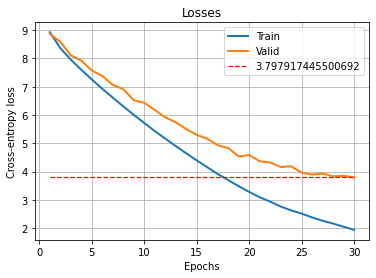

In [ ]:
# PRETRAIN
plot_losses()

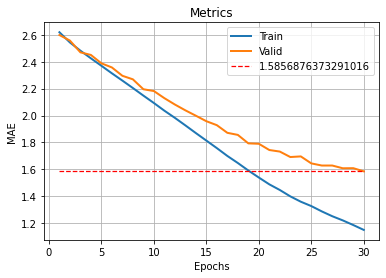

In [ ]:
plot_metrics()

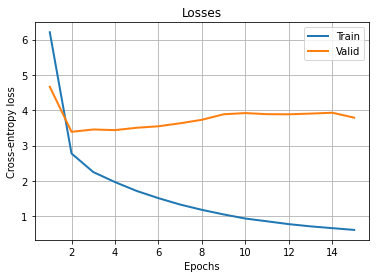

In [ ]:
# lr = 1e-4, activation=gelu, embed_size=60, linear=(1024, 512, 256)
plot_losses()

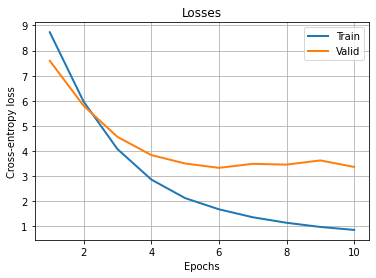

In [ ]:
# lr=1e-4, activation=relu, embed_size=60, linear=(1024, 512, 64), nheads=10
plot_losses()

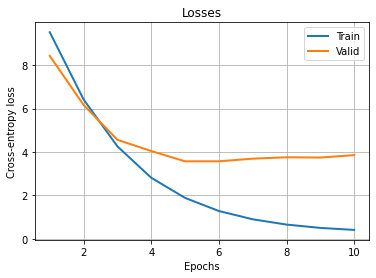

In [ ]:
# lr=1e-4, activation=relu, embed_size=60, linear=(1024, 256, 64), nheads=10
plot_losses()

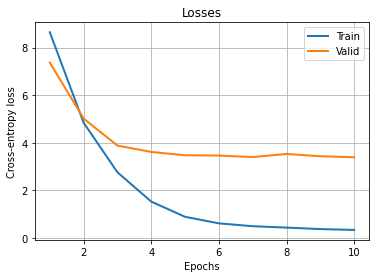

In [ ]:
# lr=1e-4, activation=relu, embed_size=200, linear=(1024, 256, 64), nheads=10
plot_losses()

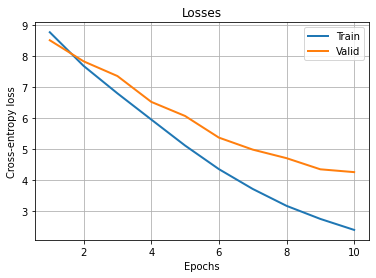

In [ ]:
# lr=2e-5, activation=relu, embed_size=200, linear=(1024, 256, 64), nheads=10
plot_losses()

In [ ]:
model = BstTransformer(len(book_lookup), len(user_lookup), sequence_length, embedding_size=120)
# model = model.to(device)
loss_func = torch.nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
all_train_losses = []
all_valid_losses = []
best_valid_loss = float('inf')
epochs = 10
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)


 Epoch1 / 10


  0%|          | 0/120 [00:00<?, ?it/s]

# Transformer with user features

In [ ]:
seq_df

,user_id,Book_title,Book_Author,time,is_valid,Year-Of-Publication,target_rating,previous_ratings,pad_mask,num_pads
0,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",7.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",9
1,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",7.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",8
2,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",5.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Fal...",7
3,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Som...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Ray...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 0, ...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 198...",9.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 7.0...","[True, True, True, True, True, True, False, Fa...",6
4,1,"([PAD], [PAD], [PAD], [PAD], [PAD], Something ...","([PAD], [PAD], [PAD], [PAD], [PAD], Ray Bradbu...","([PAD], [PAD], [PAD], [PAD], [PAD], 0, 1, 2, 3...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], 1983, 2000...",6.0,"([PAD], [PAD], [PAD], [PAD], [PAD], 7.0, 7.0, ...","[True, True, True, True, True, False, False, F...",5
...,...,...,...,...,...,...,...,...,...,...
62651,999,"(Out of Africa and, Shadows on the grass, The ...","(Isak Dinesen, Adam Davies, Zora Neale Hurston...","(20846, 20847, 20848, 20849, 20850, 20851, 208...",False,"(1985, 2002, 1978, 1999, 1993, 1994, 1999, 200...",8.0,"(10.0, 10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0,...","[False, False, False, False, False, False, Fal...",0
62652,999,"(The Frog King: A Love Story, Their eyes were ...","(Adam Davies, Zora Neale Hurston, Jill Churchi...","(20847, 20848, 20849, 20850, 20851, 20852, 208...",False,"(2002, 1978, 1999, 1993, 1994, 1999, 2002, 199...",8.0,"(10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0,...","[False, False, False, False, False, False, Fal...",0
62653,999,"(Their eyes were watching God: A novel, The Me...","(Zora Neale Hurston, Jill Churchill, H. Jackso...","(20848, 20849, 20850, 20851, 20852, 20853, 208...",False,"(1978, 1999, 1993, 1994, 1999, 2002, 1995, 198...",10.0,"(8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, ...","[False, False, False, False, False, False, Fal...",0
62654,999,(The Merchant of Menace (Jane Jeffry Mysteries...,"(Jill Churchill, H. Jackson Brown, Jane Austen...","(20849, 20850, 20851, 20852, 20853, 20854, 208...",False,"(1999, 1993, 1994, 1999, 2002, 1995, 1984, 199...",10.0,"(10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, 8.0, ...","[False, False, False, False, False, False, Fal...",0


In [ ]:
users_info["user_id"] = users_info["user_id"].astype(str)

In [ ]:
users_info['age_encoded'] = users_info['Age'].apply(lambda x: 7 if x > 79 else int(x/10))

In [ ]:
# All unique locations are collected from dataset and separated as parts of Earth(Europe, Asia or America)

continents = {'America':set(['usa', 'king of prussia', 'berkeley', 'tennessee', 'canada', 'murphysboro', 'new hampshire',
                              'fredericton', 'brazil', 'texas', 'virginia', 'wrightstown', 'south carolina',
                        'iowa city', 'apopka', 'united states', 'holtsville', 'tustin', 'bronx', 'oregon',
                        'irvine', 'far away...', 'vancouver', 'tucson', 'fayetteville', 'fort myers beach',
                        'mercer island', 'universe', 'montreal', 'bloomer', 'rockaway', 'canton', 'dominican republic', 
                        'michigan', 'california', 'cotati', 'orlando', 'milton', 'west linn', 'oklahoma', 'anaheim hills',
                        'walled lake', 'united state', 'louisiana', 'houston', 'fairfax', 'springfield', 'n/a', 'humble'
                        'west valley city', 'chicago', 'illinois', 'santa monica', 'anchorage', 'michigan usa', 'trinidad and tobago'
                        'molalla', 'reno']), 
             'Europe':set(['france', 'spain', 'austria', 'portugal', 'romania', 'germany', 'finland', 'united kingdom',
                       'ireland', 'netherlands', 'italy', 'bulgaria', 'switzerland', 'three rivers', 'new zealand',
                      'barcelona', 'norway', 'belgium', 'new york', 'halifax', 'poland', 'russia', 'cyprus', 'iceland',
                      'georgia',' bourbonnais', 'york', 'denmark', 'costa da caparica', 'leroy', 'lancaster', 'sweden', 
                      'czech republic', 'bristol', 'madera', 'oxford', 'arco']),
             'Asia':set(['taiwan', 'iran', 'malaysia', 'philippines', 'japan', 'australia', 'qatar', 'china', 'hong kong', 'burma'
                    'kuwait', 'singapore', 'phillipines'])}

In [ ]:
users_info['location_encoded'] = users_info['Location'].apply(lambda x: 0 if x in continents['America']
                                                              else 1 if x in continents['Europe']
                                                              else 2)
users_info.head()

,user_id,Location,Age,age_encoded,location_encoded
0,1,"minneapolis, minnesota, usa",24,2,2
1,2,"san diego, california, usa",20,2,2
2,3,"novinger, missouri, usa",16,1,2
3,4,"sonoma, california, usa",34,3,2
4,5,"berkeley, california, usa",23,2,2


In [ ]:
seq_with_user_features = pd.merge(seq_df, users_info)
seq_with_user_features

,user_id,Book_title,Book_Author,time,is_valid,Year-Of-Publication,target_rating,previous_ratings,pad_mask,num_pads,Location,Age,age_encoded,location_encoded
0,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",7.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",9,"minneapolis, minnesota, usa",24,2,2
1,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",7.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",8,"minneapolis, minnesota, usa",24,2,2
2,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",5.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Fal...",7,"minneapolis, minnesota, usa",24,2,2
3,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Som...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], Ray...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 0, ...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 198...",9.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 7.0...","[True, True, True, True, True, True, False, Fa...",6,"minneapolis, minnesota, usa",24,2,2
4,1,"([PAD], [PAD], [PAD], [PAD], [PAD], Something ...","([PAD], [PAD], [PAD], [PAD], [PAD], Ray Bradbu...","([PAD], [PAD], [PAD], [PAD], [PAD], 0, 1, 2, 3...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], 1983, 2000...",6.0,"([PAD], [PAD], [PAD], [PAD], [PAD], 7.0, 7.0, ...","[True, True, True, True, True, False, False, F...",5,"minneapolis, minnesota, usa",24,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62651,999,"(Out of Africa and, Shadows on the grass, The ...","(Isak Dinesen, Adam Davies, Zora Neale Hurston...","(20846, 20847, 20848, 20849, 20850, 20851, 208...",False,"(1985, 2002, 1978, 1999, 1993, 1994, 1999, 200...",8.0,"(10.0, 10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0,...","[False, False, False, False, False, False, Fal...",0,"north vancouver, british columbia, canada",35,3,2
62652,999,"(The Frog King: A Love Story, Their eyes were ...","(Adam Davies, Zora Neale Hurston, Jill Churchi...","(20847, 20848, 20849, 20850, 20851, 20852, 208...",False,"(2002, 1978, 1999, 1993, 1994, 1999, 2002, 199...",8.0,"(10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0,...","[False, False, False, False, False, False, Fal...",0,"north vancouver, british columbia, canada",35,3,2
62653,999,"(Their eyes were watching God: A novel, The Me...","(Zora Neale Hurston, Jill Churchill, H. Jackso...","(20848, 20849, 20850, 20851, 20852, 20853, 208...",False,"(1978, 1999, 1993, 1994, 1999, 2002, 1995, 198...",10.0,"(8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, ...","[False, False, False, False, False, False, Fal...",0,"north vancouver, british columbia, canada",35,3,2
62654,999,(The Merchant of Menace (Jane Jeffry Mysteries...,"(Jill Churchill, H. Jackson Brown, Jane Austen...","(20849, 20850, 20851, 20852, 20853, 20854, 208...",False,"(1999, 1993, 1994, 1999, 2002, 1995, 1984, 199...",10.0,"(10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 8.0, 8.0, ...","[False, False, False, False, False, False, Fal...",0,"north vancouver, british columbia, canada",35,3,2


In [ ]:
class BookSequenceDataset(Dataset):
    def __init__(self, df, book_lookup, user_lookup, author_lookup, publication_lookup):
        super().__init__()
        self.df = df
        self.book_lookup = book_lookup
        self.user_lookup = user_lookup
        self.author_lookup = author_lookup
        self.publication_lookup = publication_lookup

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.df.iloc[index]
        user_id = self.user_lookup[str(data.user_id)]
        # print(data)
        book_ids = torch.tensor([self.book_lookup[title] for title in data.Book_title])
        author_ids = torch.tensor([self.author_lookup[author] for author in data.Book_Author])
        pub_year = torch.tensor([self.publication_lookup[pub_year] for pub_year in data['Year-Of-Publication']])

        previous_ratings = torch.LongTensor(
            [rating if rating != "[PAD]" else 0 for rating in data.previous_ratings]
        )
        location = torch.tensor(data.location_encoded)
        age = torch.tensor(data.age_encoded, dtype=torch.int)
        attention_mask = torch.tensor(data.pad_mask)
        target_rating = data.target_rating
        
        # encoded_features = {
        #     "user_id": user_id,
        #     "book_ids": book_ids,
        #     "ratings": previous_ratings,
        # }
 
        return torch.tensor(user_id), book_ids, author_ids, previous_ratings, age, location, pub_year, attention_mask, torch.tensor(
            target_rating, dtype=torch.float32
        )

In [ ]:
# Attempt to minimize crossing sequences in input data
indexes = [i*2 for i in range(int(len(seq_with_user_features)/2))]
min_seq_df = seq_with_user_features.iloc[indexes]
min_seq_df

,user_id,Book_title,Book_Author,time,is_valid,Year-Of-Publication,target_rating,previous_ratings,pad_mask,num_pads,Location,Age,age_encoded,location_encoded
0,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",7.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",9,"minneapolis, minnesota, usa",24,2,2
2,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",5.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Fal...",7,"minneapolis, minnesota, usa",24,2,2
4,1,"([PAD], [PAD], [PAD], [PAD], [PAD], Something ...","([PAD], [PAD], [PAD], [PAD], [PAD], Ray Bradbu...","([PAD], [PAD], [PAD], [PAD], [PAD], 0, 1, 2, 3...",False,"([PAD], [PAD], [PAD], [PAD], [PAD], 1983, 2000...",6.0,"([PAD], [PAD], [PAD], [PAD], [PAD], 7.0, 7.0, ...","[True, True, True, True, True, False, False, F...",5,"minneapolis, minnesota, usa",24,2,2
6,1,"([PAD], [PAD], [PAD], Something Wicked This Wa...","([PAD], [PAD], [PAD], Ray Bradbury, MARION ZIM...","([PAD], [PAD], [PAD], 0, 1, 2, 3, 4, 5, 6)",False,"([PAD], [PAD], [PAD], 1983, 2000, 1990, 1995, ...",9.0,"([PAD], [PAD], [PAD], 7.0, 7.0, 5.0, 9.0, 6.0,...","[True, True, True, False, False, False, False,...",3,"minneapolis, minnesota, usa",24,2,2
8,1,"([PAD], Something Wicked This Way Comes, The M...","([PAD], Ray Bradbury, MARION ZIMMER BRADLEY, N...","([PAD], 0, 1, 2, 3, 4, 5, 6, 7, 8)",False,"([PAD], 1983, 2000, 1990, 1995, 1992, 2002, 19...",8.0,"([PAD], 7.0, 7.0, 5.0, 9.0, 6.0, 5.0, 9.0, 9.0)","[True, False, False, False, False, False, Fals...",1,"minneapolis, minnesota, usa",24,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62646,999,"(The Girls' Guide to Hunting and Fishing, The ...","(Melissa Bank, Paul Laurence Dunbar, Orson Sco...","(20841, 20842, 20843, 20844, 20845, 20846, 208...",False,"(2000, 1999, 1986, 2002, 1995, 1985, 2002, 197...",10.0,"(10.0, 9.0, 8.0, 10.0, 7.0, 10.0, 10.0, 8.0, 1...","[False, False, False, False, False, False, Fal...",0,"north vancouver, british columbia, canada",35,3,2
62648,999,(Ender's Game (Ender Wiggins Saga (Paperback))...,"(Orson Scott Card, Nora Roberts, Margaret Atwo...","(20843, 20844, 20845, 20846, 20847, 20848, 208...",False,"(1986, 2002, 1995, 1985, 2002, 1978, 1999, 199...",10.0,"(8.0, 10.0, 7.0, 10.0, 10.0, 8.0, 10.0, 10.0, ...","[False, False, False, False, False, False, Fal...",0,"north vancouver, british columbia, canada",35,3,2
62650,999,"(The Robber Bride, Out of Africa and, Shadows ...","(Margaret Atwood, Isak Dinesen, Adam Davies, Z...","(20845, 20846, 20847, 20848, 20849, 20850, 208...",False,"(1995, 1985, 2002, 1978, 1999, 1993, 1994, 199...",10.0,"(7.0, 10.0, 10.0, 8.0, 10.0, 10.0, 8.0, 10.0, ...","[False, False, False, False, False, False, Fal...",0,"north vancouver, british columbia, canada",35,3,2
62652,999,"(The Frog King: A Love Story, Their eyes were ...","(Adam Davies, Zora Neale Hurston, Jill Churchi...","(20847, 20848, 20849, 20850, 20851, 20852, 208...",False,"(2002, 1978, 1999, 1993, 1994, 1999, 2002, 199...",8.0,"(10.0, 8.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0,...","[False, False, False, False, False, False, Fal...",0,"north vancouver, british columbia, canada",35,3,2


In [ ]:
# train_df = min_seq_df[min_seq_df.is_valid == False]
train_df = seq_with_user_features[seq_with_user_features.is_valid == False]
val_df = seq_with_user_features[seq_with_user_features.is_valid == True]
train_dataset = BookSequenceDataset(train_df, book_lookup, user_lookup, author_lookup, publication_lookup)
val_dataset = BookSequenceDataset(val_df, book_lookup, user_lookup, author_lookup, publication_lookup)
print(len(train_df), len(val_df))

61361 1295


In [ ]:
# train_data = TensorDataset(train_dataset, train_mask, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler = train_sampler, batch_size = 1024)

val_sampler = RandomSampler(val_dataset) # SequentialSampler(val_data)
val_dataloader = DataLoader(val_dataset, sampler = val_sampler, batch_size = 1024)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class BstTransformer(nn.Module):
    def __init__(
        self,
        books_num_unique,
        users_num_unique,
        authors_num_unique,
        sequence_length=10,
        embedding_size=512,  
        num_transformer_layers=3,
        ratings_range=(1, 10),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.books_embeddings = nn.Embedding(
            books_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.ratings_embeddings = nn.Embedding(11, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)
        self.author_embeddings = nn.Embedding(authors_num_unique, embedding_size) # TODO: EXPERIMENTS

        self.age_group_embeddings = nn.Embedding(8, 20)
        self.location_embeddings = nn.Embedding(3, 10)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=10,
                dim_feedforward=1024,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length) + 20 + 10,
                512,
            ),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Mish(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        user_id, book_ids, author_ids, previous_ratings, age_group, location, mask = inputs

        age_group = self.age_group_embeddings(age_group)
        user_id = self.user_embeddings(user_id)
        location = self.location_embeddings(location)
        # user_features = 
        # print(age_group.shape)
        user_features = torch.cat(
            (user_id, age_group, location), 1
        )
        # print(user_id.shape, age_group.shape)
        # print(user_features.shape)
        # print('=============================')
        book_history = book_ids[:, :-1]
        target_book = book_ids[:, -1]
        authors = author_ids[:, :-1]
        target_author = author_ids[:, -1]

        ratings = self.ratings_embeddings(previous_ratings)
        encoded_books = self.books_embeddings(book_history)
        encoded_target_book = self.books_embeddings(target_book)
        authors = self.author_embeddings(authors)
        target_author = self.author_embeddings(target_author)

        positions = torch.arange(
            0,
            self.sequence_length - 1,
            1,
            dtype=int,
            device=book_ids.device,
        )
        positions = self.position_embeddings(positions)

        encoded_sequence_books_with_position_and_rating = (
            encoded_books + ratings + positions + authors
        )
        # print(encoded_books.shape, ratings.shape, positions.shape)
        encoded_target_book = (encoded_target_book + target_author).unsqueeze(1)
        # print(encoded_sequence_books_with_position_and_rating.shape, encoded_target_book.shape)
        transformer_features = torch.cat(
            (encoded_sequence_books_with_position_and_rating, encoded_target_book),
            dim=1,
        )
        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        # print(transformer_output.shape)
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        # print('=============================')

        combined_output = torch.cat((transformer_output, user_features), dim=1)
        # print(combined_output.shape)
        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]

In [ ]:
# model = BstTransformer(
#     len(book_lookup), len(user_lookup), len(author_lookup), sequence_length, embedding_size=60
# )
# model = model.to(device)
# loss_func = torch.nn.MSELoss()
# mae_func = torchmetrics.MeanAbsoluteError()
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    mae_metrics = 0
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        # print(batch)
        # print("===============================================")
        user_id, book_ids, author_ids, prev_ratings, age_group, location, mask, target_rating = batch
        # model.zero_grad()
        pred_rating = model((user_id, book_ids, author_ids, prev_ratings, age_group, location, mask))
        loss = loss_func(pred_rating, target_rating)
        total_loss += loss.item()
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = pred_rating.detach().cpu().numpy()
        mae_metrics += mae_func(pred_rating.detach().cpu(), target_rating.detach().cpu())
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    mae_metrics /= len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
        
    return avg_loss, mae_metrics, total_preds

def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    mae_metrics = 0

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        user_id, book_ids, author_ids, prev_ratings, age_group, location, mask, target_rating = batch
        with torch.no_grad():
            pred_rating = model((user_id, book_ids, author_ids, prev_ratings, age_group, location, mask))
            loss = loss_func(pred_rating, target_rating)
            total_loss = total_loss + loss.item()
            # mae_metrics += mae_func(pred_rating, taget_rating)
            preds = pred_rating.detach().cpu().numpy()
            mae_metrics += mae_func(pred_rating.detach().cpu(), target_rating.detach().cpu())
            # print(mae_metrics)
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    mae_metrics /= len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    return avg_loss, mae_metrics, total_preds

In [ ]:
# all_train_losses = []
# all_valid_losses = []
# all_train_metrics = []
# all_val_metrics = []
# best_valid_loss = float('inf')
# best_val_metric = float('inf')
epochs = 15
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)

# Experiments #1

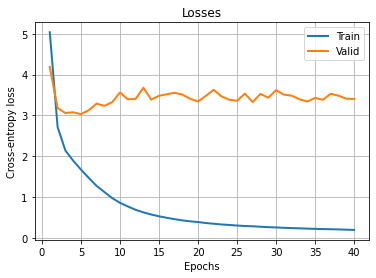

In [ ]:
# lr=5e-5, embed_len=120
plot_losses()

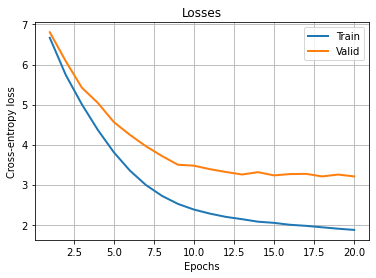

In [ ]:
 # lr=1e-5, embed_len=60
 plot_losses()

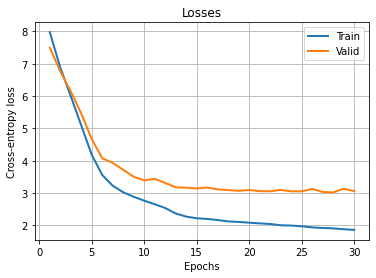

In [ ]:
# lr=1e-5, embed_len=40, nheads=4
plot_losses()

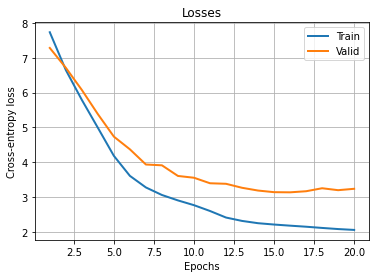

In [ ]:
# model.zero_grad() after prediction in model
plot_losses()

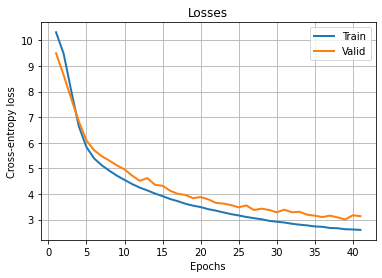

In [ ]:
# THE BEST PARAMS
# dim_feedforward=1024, full-con=(512, 256, 64)
plot_losses()

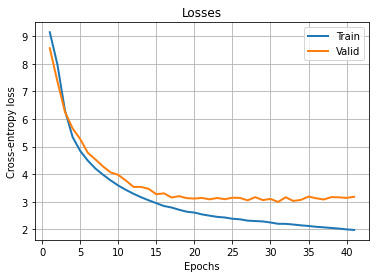

In [ ]:
# nheads=2, dim_feedforward=2048, age_group_embeddings = (8, 10), lr=2e-5
plot_losses()

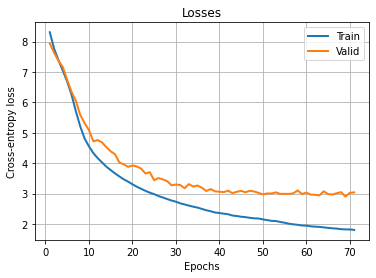

In [ ]:

plot_losses()

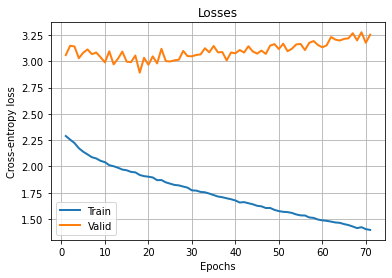

In [ ]:
# continue of the previous plot
plot_losses()

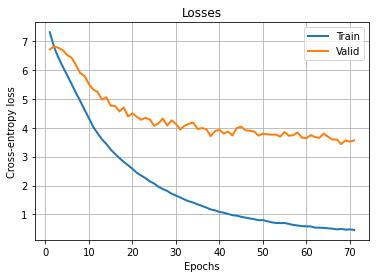

In [ ]:
# with minimized dataset (crossing fragments deleted) x5
# nhead=4, activ=gelu, lr=4e-5, dim_feedforward=1024, embed_size=60, full-con=(512, 256, 64)
plot_losses() 

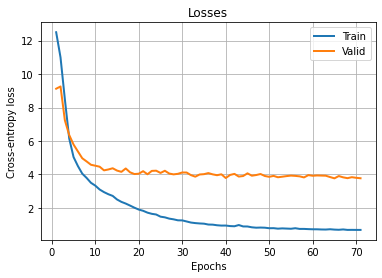

In [ ]:
# with minimized dataset (crossing fragments deleted) x5
# nhead=1, activ=gelu, lr=4e-5, dim_feedforward=2048, embed_size=50
plot_losses()

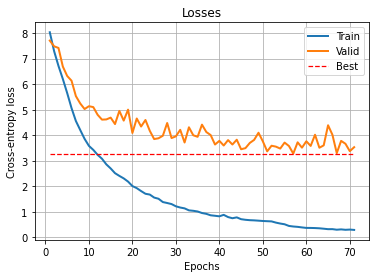

In [ ]:
# with minimized dataset (crossing fragments deleted) x7
# nhead=4, activ=gelu, lr=4e-5, dim_feedforward=1024, embed_size=60
plot_losses()

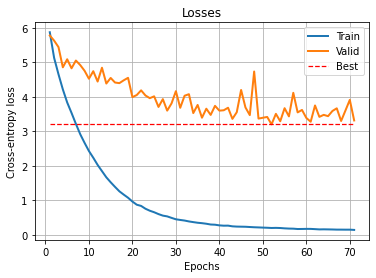

In [ ]:
# with minimized dataset (crossing fragments deleted) x7
# emded_size=120, lr=1e-5, nhead=8, dim_feed_forward=1024, age=20
plot_losses()

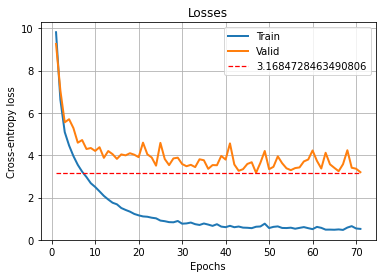

In [ ]:
 # with minimized dataset (crossing fragments deleted) x3
 # embed_size=512, lr=1e-5, nhead=8, dim_feed_forward=2048, age=20, linear=(1024, 512, 128), batch_size=256
 plot_losses()

In [ ]:
model.parameters

<bound method Module.parameters of BstTransformer(
  (books_embeddings): Embedding(14019, 512, padding_idx=0)
  (user_embeddings): Embedding(1296, 512)
  (ratings_embeddings): Embedding(11, 512, padding_idx=0)
  (position_embeddings): Embedding(10, 512)
  (age_group_embeddings): Embedding(8, 20)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  

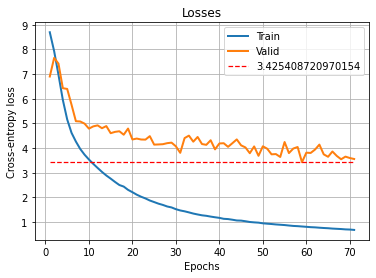

In [ ]:
 # with minimized dataset (crossing fragments deleted) x3
plot_losses()

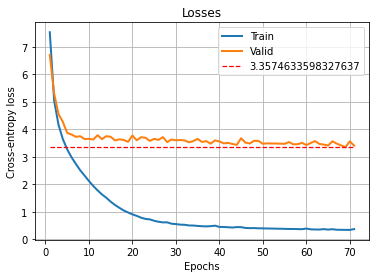

In [ ]:
# whole dataset, batch_size=512, embed_size=512
plot_losses()

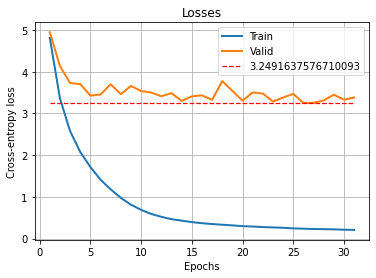

In [ ]:
# whole dataset, batch_size=128, embed_size=512, nheads=8
plot_losses()

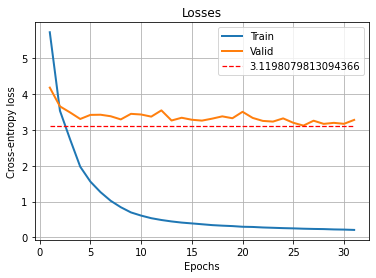

In [ ]:
# whole dataset, batch_size=64, embed_size=512, nheads=8
plot_losses()

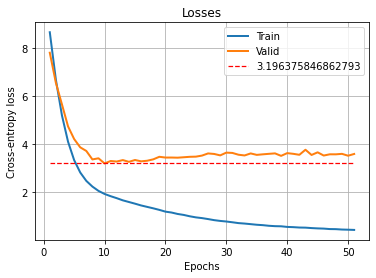

In [ ]:
# dataset / 2, batch_size=64, emdeb_size=128, nheads=2, lr=1e-5, dim_feedforward=1024, full-con=(512, 256, 128)
plot_losses()

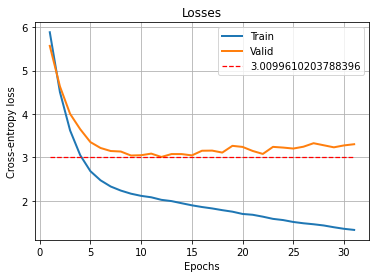

In [ ]:
# dataset / 2, batch_size=64, emdeb_size=64, nheads=2, lr=1e-5, dim_feedforward=1024, full-con=(512, 256, 128)
plot_losses()

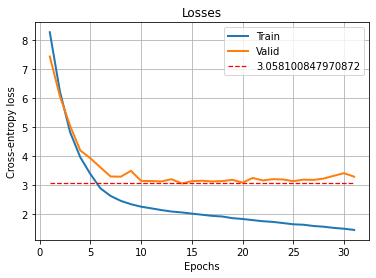

In [ ]:
# best of last two params, and transformer_layers=2
plot_losses()

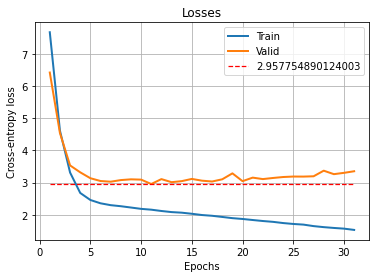

In [ ]:
# whole dataset, batch_size=64, embed_size=128, nheads=2, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=2
plot_losses()

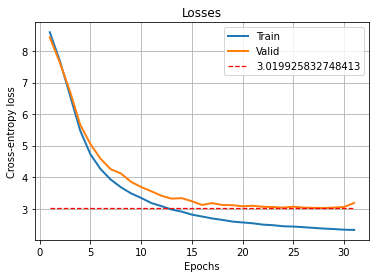

In [ ]:
# whole dataset, batch_size=512, embed_size=64, nheads=2, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=2
plot_losses()

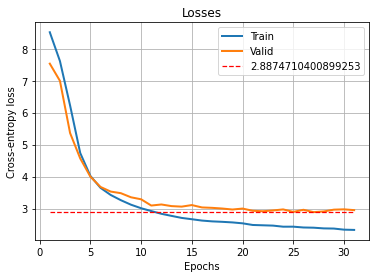

In [ ]:
# whole dataset, batch_size=512, embed_size=64, nheads=4, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=3
plot_losses()

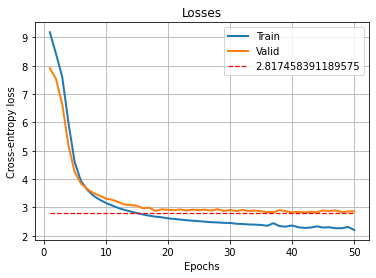

In [ ]:
# whole dataset, batch_size=768, embed_size=64, nheads=2, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=3
plot_losses()

In [ ]:
# transformer_layers=2
# whole dataset, batch_size=768, embed_size=64, nheads=2, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=2
plot_losses()

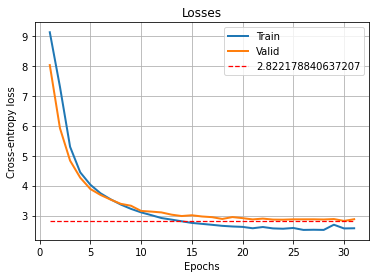

In [ ]:
# whole dataset, batch_size=768, embed_size=64, nheads=4, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=6
plot_losses()

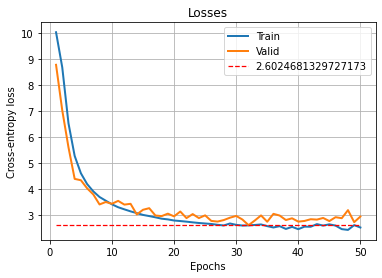

In [ ]:
# whole dataset, batch_size=1024, embed_size=64, nheads=4, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=6
plot_losses()

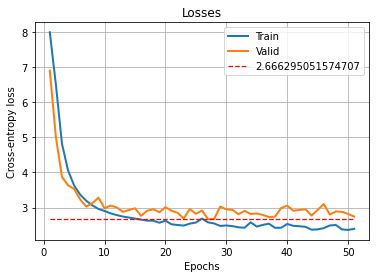

In [ ]:
# whole dataset, batch_size=2048, embed_size=120, nheads=4, dim_feedforward=2048, full-con=(512, 256, 128), transformer_layers=6
plot_losses()

In [ ]:
all_train_losses = []
all_valid_losses = []
best_valid_loss = float('inf')
epochs = 51
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)


 Epoch1 / 51


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]



Training loss: 5.057
Validation loss: 2.989

 Epoch2 / 51


100%|██████████| 2/2 [00:00<00:00,  4.54it/s]



Training loss: 2.868
Validation loss: 2.787

 Epoch3 / 51


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]



Training loss: 2.655
Validation loss: 3.090

 Epoch4 / 51


100%|██████████| 2/2 [00:00<00:00,  3.83it/s]



Training loss: 2.536
Validation loss: 2.831

 Epoch5 / 51


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]



Training loss: 2.679
Validation loss: 2.729

 Epoch6 / 51


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]



Training loss: 2.634
Validation loss: 2.956

 Epoch7 / 51


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]



Training loss: 2.676
Validation loss: 2.697

 Epoch8 / 51


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]



Training loss: 2.377
Validation loss: 2.835

 Epoch9 / 51


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]



Training loss: 2.458
Validation loss: 2.965

 Epoch10 / 51


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]



Training loss: 2.316
Validation loss: 2.677

 Epoch11 / 51


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]



Training loss: 2.193
Validation loss: 2.909

 Epoch12 / 51


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]



Training loss: 2.093
Validation loss: 2.899

 Epoch13 / 51


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]



Training loss: 1.989
Validation loss: 3.053

 Epoch14 / 51


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]



Training loss: 1.871
Validation loss: 2.900

 Epoch15 / 51


100%|██████████| 2/2 [00:00<00:00,  4.39it/s]



Training loss: 1.746
Validation loss: 2.950

 Epoch16 / 51


100%|██████████| 2/2 [00:00<00:00,  4.29it/s]



Training loss: 1.632
Validation loss: 3.049

 Epoch17 / 51


100%|██████████| 2/2 [00:00<00:00,  4.25it/s]



Training loss: 1.510
Validation loss: 3.232

 Epoch18 / 51


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]



Training loss: 1.401
Validation loss: 3.345

 Epoch19 / 51


100%|██████████| 2/2 [00:00<00:00,  4.06it/s]



Training loss: 1.291
Validation loss: 3.244

 Epoch20 / 51


100%|██████████| 2/2 [00:00<00:00,  4.23it/s]



Training loss: 1.196
Validation loss: 3.339

 Epoch21 / 51


100%|██████████| 2/2 [00:00<00:00,  4.45it/s]



Training loss: 1.101
Validation loss: 3.559

 Epoch22 / 51


100%|██████████| 2/2 [00:00<00:00,  4.29it/s]



Training loss: 1.022
Validation loss: 3.460

 Epoch23 / 51


100%|██████████| 2/2 [00:00<00:00,  4.29it/s]



Training loss: 0.955
Validation loss: 3.527

 Epoch24 / 51


100%|██████████| 2/2 [00:00<00:00,  3.99it/s]



Training loss: 0.886
Validation loss: 3.531

 Epoch25 / 51


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]



Training loss: 0.824
Validation loss: 3.469

 Epoch26 / 51


100%|██████████| 2/2 [00:00<00:00,  3.95it/s]



Training loss: 0.768
Validation loss: 3.326

 Epoch27 / 51


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]



Training loss: 0.723
Validation loss: 3.872

 Epoch28 / 51


100%|██████████| 2/2 [00:00<00:00,  4.33it/s]



Training loss: 0.670
Validation loss: 3.315

 Epoch29 / 51


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]



Training loss: 0.639
Validation loss: 3.574

 Epoch30 / 51


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]



Training loss: 0.598
Validation loss: 3.498

 Epoch31 / 51


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]



Training loss: 0.569
Validation loss: 3.411

 Epoch32 / 51


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]



Training loss: 0.540
Validation loss: 3.378

 Epoch33 / 51


100%|██████████| 2/2 [00:00<00:00,  3.84it/s]



Training loss: 0.523
Validation loss: 3.539

 Epoch34 / 51


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]



Training loss: 0.494
Validation loss: 3.643

 Epoch35 / 51


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]



Training loss: 0.478
Validation loss: 3.439

 Epoch36 / 51


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]



Training loss: 0.460
Validation loss: 3.395

 Epoch37 / 51


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]



Training loss: 0.438
Validation loss: 3.465

 Epoch38 / 51


100%|██████████| 2/2 [00:00<00:00,  4.06it/s]



Training loss: 0.423
Validation loss: 3.678

 Epoch39 / 51


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]



Training loss: 0.412
Validation loss: 3.652

 Epoch40 / 51


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]



Training loss: 0.396
Validation loss: 3.774

 Epoch41 / 51


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]



Training loss: 0.385
Validation loss: 3.527

 Epoch42 / 51


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]



Training loss: 0.377
Validation loss: 3.391

 Epoch43 / 51


100%|██████████| 2/2 [00:00<00:00,  3.88it/s]



Training loss: 0.364
Validation loss: 3.290

 Epoch44 / 51


100%|██████████| 2/2 [00:00<00:00,  4.12it/s]



Training loss: 0.349
Validation loss: 3.541

 Epoch45 / 51


100%|██████████| 2/2 [00:00<00:00,  4.38it/s]



Training loss: 0.336
Validation loss: 3.427

 Epoch46 / 51


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]



Training loss: 0.330
Validation loss: 3.507

 Epoch47 / 51


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]



Training loss: 0.322
Validation loss: 3.428

 Epoch48 / 51


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]



Training loss: 0.315
Validation loss: 3.421

 Epoch49 / 51


100%|██████████| 2/2 [00:00<00:00,  3.80it/s]



Training loss: 0.308
Validation loss: 3.401

 Epoch50 / 51


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]



Training loss: 0.299
Validation loss: 3.562

 Epoch51 / 51


100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Training loss: 0.290
Validation loss: 3.504


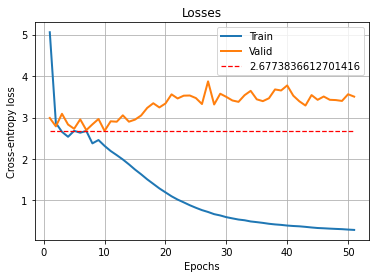

In [ ]:
# lr=1e-4, whole dataset, batch_size=2048, embed_size=120, nheads=4, dim_feedforward=2048, full-con=(512, 256, 128), transformer_layers=6
plot_losses()

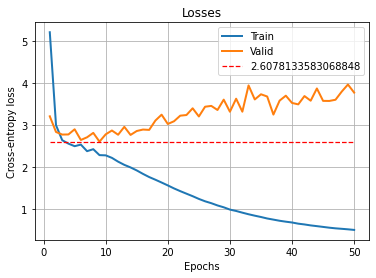

In [ ]:
# lr=1e-4, whole dataset, batch_size=1024, embed_size=64, nheads=4, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=6
plot_losses()

In [ ]:
# research lr=4e-5, nheads=6(8, 12) with embed_size=60

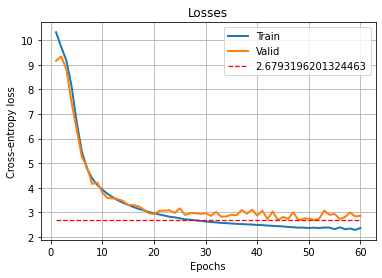

In [ ]:
# lr=1e-4, whole dataset, batch_size=1024, embed_size=64, nheads=8, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=3
plot_losses()

# Experiments #2
- with location, age data about user
- with position, book, author and rating embeddings

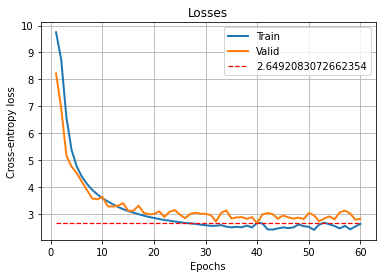

In [ ]:
# whole dataset, batch_size=1024, embed_size=64, nheads=4, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=6
plot_losses()

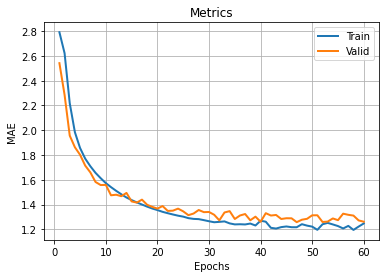

In [ ]:
plot_metrics()

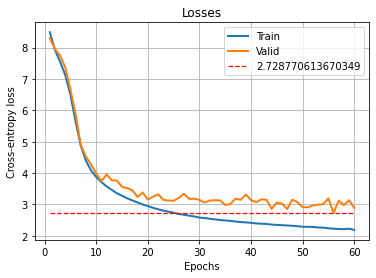

In [ ]:
# lr=1e-5, whole dataset, batch_size=1024, embed_size=60, nheads=10, dim_feedforward=1024, full-con=(512, 256, 128), transformer_layers=3
plot_losses()

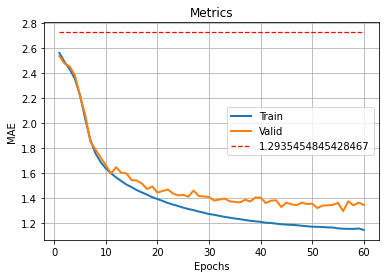

In [ ]:
plot_metrics()

# Experiments #3
With larger learning rate

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 25
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 25


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


tensor(1.2903)
tensor(2.5323)

Training loss: 3.438
Validation loss: 2.891
Training MAE: 1.456256628036499
Validation MAE: 1.2661653757095337

 Epoch2 / 25


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


tensor(1.2953)
tensor(2.5541)

Training loss: 2.373
Validation loss: 2.786
Training MAE: 1.1742287874221802
Validation MAE: 1.2770662307739258

 Epoch3 / 25


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


tensor(1.2990)
tensor(2.5857)

Training loss: 2.309
Validation loss: 2.841
Training MAE: 1.1570191383361816
Validation MAE: 1.2928578853607178

 Epoch4 / 25


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


tensor(1.2997)
tensor(2.6452)

Training loss: 2.256
Validation loss: 2.904
Training MAE: 1.1436673402786255
Validation MAE: 1.3226159811019897

 Epoch5 / 25


 50%|█████     | 1/2 [00:00<00:00,  2.63it/s]

tensor(1.2707)


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


tensor(2.5633)

Training loss: 2.193
Validation loss: 2.943
Training MAE: 1.1284197568893433
Validation MAE: 1.2816672325134277

 Epoch6 / 25


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


tensor(1.2998)
tensor(2.7179)

Training loss: 2.102
Validation loss: 3.124
Training MAE: 1.1027264595031738
Validation MAE: 1.358931064605713

 Epoch7 / 25


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


tensor(1.3265)
tensor(2.7459)

Training loss: 1.997
Validation loss: 3.221
Training MAE: 1.0751019716262817
Validation MAE: 1.372936487197876

 Epoch8 / 25


100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


tensor(1.3011)
tensor(2.7185)

Training loss: 1.836
Validation loss: 3.143
Training MAE: 1.032189965248108
Validation MAE: 1.3592495918273926

 Epoch9 / 25


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


tensor(1.3489)
tensor(2.7520)

Training loss: 1.669
Validation loss: 3.222
Training MAE: 0.9860778450965881
Validation MAE: 1.3759827613830566

 Epoch10 / 25


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


tensor(1.3390)
tensor(2.7790)

Training loss: 1.477
Validation loss: 3.412
Training MAE: 0.9329663515090942
Validation MAE: 1.3895026445388794

 Epoch11 / 25


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


tensor(1.3950)
tensor(2.7120)

Training loss: 1.293
Validation loss: 3.205
Training MAE: 0.8738677501678467
Validation MAE: 1.3559792041778564

 Epoch12 / 25


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


tensor(1.3505)
tensor(2.7285)

Training loss: 1.117
Validation loss: 3.271
Training MAE: 0.8165320158004761
Validation MAE: 1.364229679107666

 Epoch13 / 25


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


tensor(1.4191)
tensor(2.9500)

Training loss: 0.977
Validation loss: 3.732
Training MAE: 0.7672494649887085
Validation MAE: 1.474987506866455

 Epoch14 / 25


100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


tensor(1.4330)
tensor(2.8208)

Training loss: 0.839
Validation loss: 3.473
Training MAE: 0.7135826945304871
Validation MAE: 1.4104081392288208

 Epoch15 / 25


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


tensor(1.4218)
tensor(2.7786)

Training loss: 0.746
Validation loss: 3.368
Training MAE: 0.6744874119758606
Validation MAE: 1.3892805576324463

 Epoch16 / 25


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


tensor(1.4481)
tensor(2.9387)

Training loss: 0.658
Validation loss: 3.602
Training MAE: 0.6332538723945618
Validation MAE: 1.4693278074264526

 Epoch17 / 25


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


tensor(1.4322)
tensor(2.8154)

Training loss: 0.596
Validation loss: 3.479
Training MAE: 0.6045016646385193
Validation MAE: 1.40767502784729

 Epoch18 / 25


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


tensor(1.4114)
tensor(2.9553)

Training loss: 0.546
Validation loss: 3.728
Training MAE: 0.5790589451789856
Validation MAE: 1.4776360988616943

 Epoch19 / 25


100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


tensor(1.4111)
tensor(2.8620)

Training loss: 0.498
Validation loss: 3.551
Training MAE: 0.5520886182785034
Validation MAE: 1.430992603302002

 Epoch20 / 25


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


tensor(1.3922)
tensor(2.8559)

Training loss: 0.459
Validation loss: 3.566
Training MAE: 0.5317547917366028
Validation MAE: 1.4279311895370483

 Epoch21 / 25


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


tensor(1.4142)
tensor(2.8541)

Training loss: 0.432
Validation loss: 3.513
Training MAE: 0.5155221819877625
Validation MAE: 1.4270541667938232

 Epoch22 / 25


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


tensor(1.4083)
tensor(2.7960)

Training loss: 0.398
Validation loss: 3.472
Training MAE: 0.493774950504303
Validation MAE: 1.3980052471160889

 Epoch23 / 25


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


tensor(1.4001)
tensor(2.8300)

Training loss: 0.380
Validation loss: 3.408
Training MAE: 0.4818137586116791
Validation MAE: 1.4149928092956543

 Epoch24 / 25


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


tensor(1.3860)
tensor(2.8662)

Training loss: 0.354
Validation loss: 3.575
Training MAE: 0.4652027189731598
Validation MAE: 1.4330790042877197

 Epoch25 / 25


100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

tensor(1.3927)
tensor(2.8835)

Training loss: 0.336
Validation loss: 3.451
Training MAE: 0.4535366892814636
Validation MAE: 1.4417585134506226


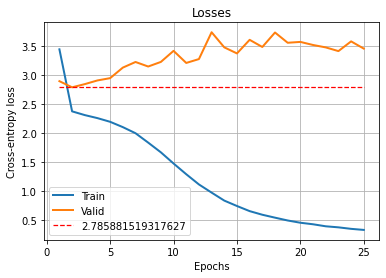

In [ ]:
# embed_size = 50, lr = 1e-3, 
plot_losses()

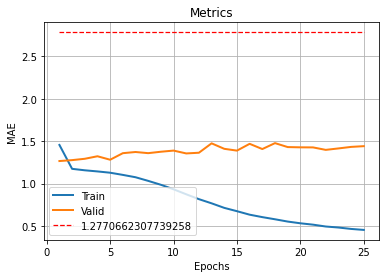

In [ ]:
plot_metrics()

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 25
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 25


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


tensor(1.5090)
tensor(2.9579)

Training loss: 6.260
Validation loss: 3.380
Training MAE: 2.1331207752227783
Validation MAE: 1.4789268970489502

 Epoch2 / 25


100%|██████████| 2/2 [00:00<00:00,  6.15it/s]


tensor(1.3663)
tensor(2.6754)

Training loss: 3.174
Validation loss: 2.934
Training MAE: 1.4444928169250488
Validation MAE: 1.3377206325531006

 Epoch3 / 25


100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


tensor(1.3241)
tensor(2.6149)

Training loss: 2.691
Validation loss: 2.867
Training MAE: 1.2989821434020996
Validation MAE: 1.307464599609375

 Epoch4 / 25


100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


tensor(1.2850)
tensor(2.7167)

Training loss: 2.542
Validation loss: 3.091
Training MAE: 1.2440077066421509
Validation MAE: 1.358357548713684

 Epoch5 / 25


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


tensor(1.2835)
tensor(2.6018)

Training loss: 2.543
Validation loss: 2.964
Training MAE: 1.2336270809173584
Validation MAE: 1.3009182214736938

 Epoch6 / 25


100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


tensor(1.2556)
tensor(2.6152)

Training loss: 2.449
Validation loss: 2.943
Training MAE: 1.2095988988876343
Validation MAE: 1.3075931072235107

 Epoch7 / 25


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


tensor(1.2920)
tensor(2.5429)

Training loss: 2.394
Validation loss: 2.819
Training MAE: 1.1937522888183594
Validation MAE: 1.2714745998382568

 Epoch8 / 25


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


tensor(1.2975)
tensor(2.5990)

Training loss: 2.311
Validation loss: 2.867
Training MAE: 1.170206069946289
Validation MAE: 1.2995141744613647

 Epoch9 / 25


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


tensor(1.3224)
tensor(2.5767)

Training loss: 2.264
Validation loss: 2.825
Training MAE: 1.1576818227767944
Validation MAE: 1.2883658409118652

 Epoch10 / 25


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


tensor(1.3079)
tensor(2.6557)

Training loss: 2.250
Validation loss: 2.959
Training MAE: 1.1551005840301514
Validation MAE: 1.3278720378875732

 Epoch11 / 25


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


tensor(1.3679)
tensor(2.6420)

Training loss: 2.128
Validation loss: 3.011
Training MAE: 1.1221157312393188
Validation MAE: 1.3209995031356812

 Epoch12 / 25


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


tensor(1.3410)
tensor(2.6895)

Training loss: 2.069
Validation loss: 3.001
Training MAE: 1.1095951795578003
Validation MAE: 1.3447320461273193

 Epoch13 / 25


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


tensor(1.3483)
tensor(2.7262)

Training loss: 1.989
Validation loss: 3.155
Training MAE: 1.0880039930343628
Validation MAE: 1.3631067276000977

 Epoch14 / 25


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


tensor(1.4087)
tensor(2.8554)

Training loss: 1.915
Validation loss: 3.418
Training MAE: 1.0733317136764526
Validation MAE: 1.427712082862854

 Epoch15 / 25


100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


tensor(1.3201)
tensor(2.7554)

Training loss: 1.805
Validation loss: 3.214
Training MAE: 1.0417309999465942
Validation MAE: 1.3776922225952148

 Epoch16 / 25


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


tensor(1.3819)
tensor(2.7800)

Training loss: 1.715
Validation loss: 3.222
Training MAE: 1.0180046558380127
Validation MAE: 1.389981985092163

 Epoch17 / 25


100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


tensor(1.3653)
tensor(2.7688)

Training loss: 1.629
Validation loss: 3.211
Training MAE: 0.9904657006263733
Validation MAE: 1.3844215869903564

 Epoch18 / 25


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


tensor(1.4171)
tensor(2.7965)

Training loss: 1.538
Validation loss: 3.299
Training MAE: 0.9627181887626648
Validation MAE: 1.3982505798339844

 Epoch19 / 25


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


tensor(1.4145)
tensor(2.7781)

Training loss: 1.463
Validation loss: 3.341
Training MAE: 0.9380176663398743
Validation MAE: 1.3890438079833984

 Epoch20 / 25


100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


tensor(1.4188)
tensor(2.8248)

Training loss: 1.395
Validation loss: 3.318
Training MAE: 0.9163989424705505
Validation MAE: 1.412383794784546

 Epoch21 / 25


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


tensor(1.4508)
tensor(2.8894)

Training loss: 1.337
Validation loss: 3.563
Training MAE: 0.8996307849884033
Validation MAE: 1.4447214603424072

 Epoch22 / 25


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


tensor(1.4636)
tensor(2.7759)

Training loss: 1.280
Validation loss: 3.320
Training MAE: 0.8805297613143921
Validation MAE: 1.387972354888916

 Epoch23 / 25


100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


tensor(1.4431)
tensor(2.8008)

Training loss: 1.216
Validation loss: 3.348
Training MAE: 0.8599430322647095
Validation MAE: 1.40040922164917

 Epoch24 / 25


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


tensor(1.4469)
tensor(2.8913)

Training loss: 1.154
Validation loss: 3.577
Training MAE: 0.8392488956451416
Validation MAE: 1.445662498474121

 Epoch25 / 25


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

tensor(1.4515)
tensor(2.9033)

Training loss: 1.109
Validation loss: 3.564
Training MAE: 0.8219066262245178
Validation MAE: 1.4516711235046387


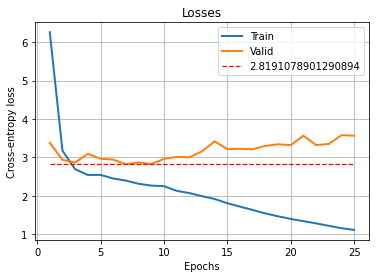

In [ ]:
# embed_size = 60
plot_losses()

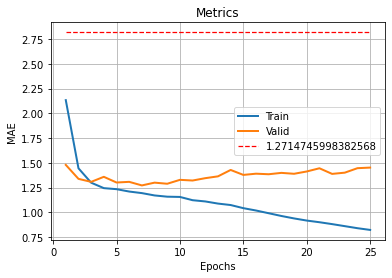

In [ ]:
plot_metrics()

In [ ]:
model = BstTransformer(
    len(book_lookup), len(user_lookup), len(author_lookup), sequence_length, embedding_size=80
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()#torch.nn.MAELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 25
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 25


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

tensor(1.6237)
tensor(3.2577)



Training loss: 7.157
Validation loss: 3.955
Training MAE: 2.298084020614624
Validation MAE: 1.6288378238677979

 Epoch2 / 25


100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

tensor(1.3412)
tensor(2.7583)



Training loss: 3.289
Validation loss: 2.999
Training MAE: 1.4769757986068726
Validation MAE: 1.3791515827178955

 Epoch3 / 25


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

tensor(1.3129)
tensor(2.6558)



Training loss: 2.712
Validation loss: 2.942
Training MAE: 1.3009536266326904
Validation MAE: 1.3279080390930176

 Epoch4 / 25


100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

tensor(1.2914)
tensor(2.6444)



Training loss: 2.559
Validation loss: 2.895
Training MAE: 1.2416551113128662
Validation MAE: 1.3221869468688965

 Epoch5 / 25


100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


tensor(1.2953)
tensor(2.6361)

Training loss: 2.498
Validation loss: 2.930
Training MAE: 1.2273650169372559
Validation MAE: 1.3180327415466309

 Epoch6 / 25


100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


tensor(1.3080)
tensor(2.5434)

Training loss: 2.656
Validation loss: 2.730
Training MAE: 1.2594937086105347
Validation MAE: 1.271712064743042

 Epoch7 / 25


 50%|█████     | 1/2 [00:00<00:00,  2.32it/s]

tensor(1.2965)


100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


tensor(2.6366)

Training loss: 2.486
Validation loss: 2.907
Training MAE: 1.2137426137924194
Validation MAE: 1.3182916641235352

 Epoch8 / 25


100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

tensor(1.3042)
tensor(2.6346)


100%|██████████| 2/2 [00:00<00:00,  3.88it/s]



Training loss: 2.351
Validation loss: 2.960
Training MAE: 1.179018497467041
Validation MAE: 1.3172760009765625

 Epoch9 / 25


100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

tensor(1.3363)
tensor(2.6190)



Training loss: 2.266
Validation loss: 2.880
Training MAE: 1.159170150756836
Validation MAE: 1.3094775676727295

 Epoch10 / 25


100%|██████████| 2/2 [00:00<00:00,  4.35it/s]


tensor(1.3312)
tensor(2.6369)

Training loss: 2.183
Validation loss: 2.970
Training MAE: 1.1350123882293701
Validation MAE: 1.3184568881988525

 Epoch11 / 25


 50%|█████     | 1/2 [00:00<00:00,  3.68it/s]

tensor(1.3774)


100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


tensor(2.8514)

Training loss: 2.079
Validation loss: 3.314
Training MAE: 1.109323263168335
Validation MAE: 1.4257181882858276

 Epoch12 / 25


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


tensor(1.3534)
tensor(2.7771)

Training loss: 2.012
Validation loss: 3.221
Training MAE: 1.0924110412597656
Validation MAE: 1.388550043106079

 Epoch13 / 25


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


tensor(1.3842)
tensor(2.7516)

Training loss: 1.891
Validation loss: 3.073
Training MAE: 1.0610706806182861
Validation MAE: 1.375788688659668

 Epoch14 / 25


100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


tensor(1.3859)
tensor(2.8674)

Training loss: 1.821
Validation loss: 3.360
Training MAE: 1.0426207780838013
Validation MAE: 1.433702826499939

 Epoch15 / 25


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


tensor(1.4313)
tensor(2.7365)

Training loss: 1.718
Validation loss: 3.138
Training MAE: 1.013812780380249
Validation MAE: 1.3682303428649902

 Epoch16 / 25


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


tensor(1.3954)
tensor(2.7745)

Training loss: 1.629
Validation loss: 3.268
Training MAE: 0.9885889887809753
Validation MAE: 1.387228012084961

 Epoch17 / 25


 50%|█████     | 1/2 [00:00<00:00,  3.02it/s]

tensor(1.3782)


100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


tensor(2.7563)

Training loss: 1.510
Validation loss: 3.270
Training MAE: 0.9571640491485596
Validation MAE: 1.378139853477478

 Epoch18 / 25


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

tensor(1.3988)
tensor(2.7930)


100%|██████████| 2/2 [00:00<00:00,  4.30it/s]



Training loss: 1.414
Validation loss: 3.372
Training MAE: 0.9251481294631958
Validation MAE: 1.396521806716919

 Epoch19 / 25


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


tensor(1.4643)
tensor(2.8544)

Training loss: 1.333
Validation loss: 3.326
Training MAE: 0.9011661410331726
Validation MAE: 1.4271860122680664

 Epoch20 / 25


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


tensor(1.4473)
tensor(2.7972)

Training loss: 1.235
Validation loss: 3.334
Training MAE: 0.8711707592010498
Validation MAE: 1.3986051082611084

 Epoch21 / 25


100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


tensor(1.4329)
tensor(2.8707)

Training loss: 1.154
Validation loss: 3.478
Training MAE: 0.8411509394645691
Validation MAE: 1.435359001159668

 Epoch22 / 25


100%|██████████| 2/2 [00:00<00:00,  4.30it/s]


tensor(1.4193)
tensor(2.8836)

Training loss: 1.079
Validation loss: 3.458
Training MAE: 0.8139168620109558
Validation MAE: 1.4417788982391357

 Epoch23 / 25


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


tensor(1.4482)
tensor(2.8626)

Training loss: 1.006
Validation loss: 3.479
Training MAE: 0.7859929800033569
Validation MAE: 1.4313147068023682

 Epoch24 / 25


100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

tensor(1.4498)
tensor(2.8219)


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]



Training loss: 0.955
Validation loss: 3.472
Training MAE: 0.766493022441864
Validation MAE: 1.4109411239624023

 Epoch25 / 25


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

tensor(1.4213)
tensor(2.8188)

Training loss: 0.896
Validation loss: 3.425
Training MAE: 0.7420912981033325
Validation MAE: 1.4093800783157349


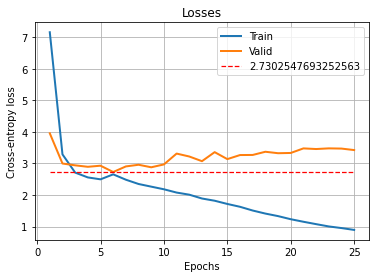

In [ ]:
# embed_size = 60
plot_losses()

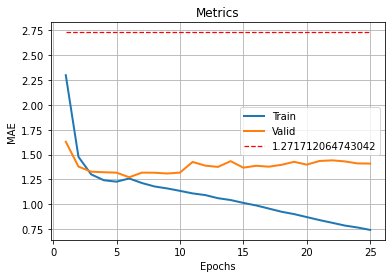

In [ ]:
plot_metrics()

In [ ]:
model = BstTransformer(
    len(book_lookup), len(user_lookup), len(author_lookup), sequence_length, embedding_size=100
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()#torch.nn.MAELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 25
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 25


100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


tensor(1.5670)
tensor(3.0438)

Training loss: 5.913
Validation loss: 3.520
Training MAE: 2.077000379562378
Validation MAE: 1.5219035148620605

 Epoch2 / 25


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


tensor(1.3635)
tensor(2.6711)

Training loss: 3.181
Validation loss: 2.933
Training MAE: 1.454201340675354
Validation MAE: 1.3355433940887451

 Epoch3 / 25


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


tensor(1.2726)
tensor(2.7386)

Training loss: 2.656
Validation loss: 3.212
Training MAE: 1.2876302003860474
Validation MAE: 1.369282603263855

 Epoch4 / 25


100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


tensor(1.2943)
tensor(2.6215)

Training loss: 2.483
Validation loss: 2.959
Training MAE: 1.2282578945159912
Validation MAE: 1.3107328414916992

 Epoch5 / 25


100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


tensor(1.3069)
tensor(2.5841)

Training loss: 2.375
Validation loss: 2.858
Training MAE: 1.1924554109573364
Validation MAE: 1.2920618057250977

 Epoch6 / 25


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


tensor(1.3286)
tensor(2.6087)

Training loss: 2.338
Validation loss: 2.864
Training MAE: 1.1804828643798828
Validation MAE: 1.304373025894165

 Epoch7 / 25


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


tensor(1.3091)
tensor(2.6412)

Training loss: 2.247
Validation loss: 2.983
Training MAE: 1.156124472618103
Validation MAE: 1.3206052780151367

 Epoch8 / 25


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


tensor(1.3463)
tensor(2.7556)

Training loss: 2.137
Validation loss: 3.023
Training MAE: 1.1272618770599365
Validation MAE: 1.3777997493743896

 Epoch9 / 25


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


tensor(1.3615)
tensor(2.6653)

Training loss: 2.038
Validation loss: 2.906
Training MAE: 1.1025797128677368
Validation MAE: 1.3326451778411865

 Epoch10 / 25


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


tensor(1.3878)
tensor(2.8437)

Training loss: 1.907
Validation loss: 3.291
Training MAE: 1.071762204170227
Validation MAE: 1.4218392372131348

 Epoch11 / 25


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


tensor(1.3911)
tensor(2.8638)

Training loss: 1.778
Validation loss: 3.347
Training MAE: 1.0318570137023926
Validation MAE: 1.4319069385528564

 Epoch12 / 25


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


tensor(1.4014)
tensor(2.8342)

Training loss: 1.644
Validation loss: 3.256
Training MAE: 0.9965202212333679
Validation MAE: 1.417078971862793

 Epoch13 / 25


100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


tensor(1.4211)
tensor(2.8809)

Training loss: 1.523
Validation loss: 3.342
Training MAE: 0.9584035873413086
Validation MAE: 1.440443992614746

 Epoch14 / 25


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


tensor(1.3466)
tensor(2.7099)

Training loss: 1.374
Validation loss: 3.184
Training MAE: 0.9180812239646912
Validation MAE: 1.3549365997314453

 Epoch15 / 25


100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


tensor(1.3348)
tensor(2.7844)

Training loss: 1.264
Validation loss: 3.332
Training MAE: 0.8794042468070984
Validation MAE: 1.3921958208084106

 Epoch16 / 25


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


tensor(1.3478)
tensor(2.8376)

Training loss: 1.156
Validation loss: 3.366
Training MAE: 0.8418278098106384
Validation MAE: 1.4188053607940674

 Epoch17 / 25


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


tensor(1.3809)
tensor(2.7281)

Training loss: 1.063
Validation loss: 3.184
Training MAE: 0.8069857954978943
Validation MAE: 1.364041805267334

 Epoch18 / 25


100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


tensor(1.4157)
tensor(2.6413)

Training loss: 0.984
Validation loss: 3.073
Training MAE: 0.7757759690284729
Validation MAE: 1.3206592798233032

 Epoch19 / 25


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


tensor(1.3863)
tensor(2.6607)

Training loss: 0.911
Validation loss: 3.078
Training MAE: 0.7482778429985046
Validation MAE: 1.330333948135376

 Epoch20 / 25


100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


tensor(1.3675)
tensor(2.7495)

Training loss: 0.849
Validation loss: 3.243
Training MAE: 0.7234927415847778
Validation MAE: 1.3747296333312988

 Epoch21 / 25


100%|██████████| 2/2 [00:00<00:00,  5.05it/s]


tensor(1.3614)
tensor(2.7480)

Training loss: 0.785
Validation loss: 3.341
Training MAE: 0.6955509781837463
Validation MAE: 1.3740242719650269

 Epoch22 / 25


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


tensor(1.4223)
tensor(2.8149)

Training loss: 0.742
Validation loss: 3.327
Training MAE: 0.6785436868667603
Validation MAE: 1.4074673652648926

 Epoch23 / 25


100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


tensor(1.3961)
tensor(2.6726)

Training loss: 0.688
Validation loss: 3.186
Training MAE: 0.6537129282951355
Validation MAE: 1.3362829685211182

 Epoch24 / 25


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


tensor(1.3980)
tensor(2.7351)

Training loss: 0.650
Validation loss: 3.242
Training MAE: 0.6346589922904968
Validation MAE: 1.3675286769866943

 Epoch25 / 25


100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

tensor(1.3933)
tensor(2.6982)

Training loss: 0.615
Validation loss: 3.170
Training MAE: 0.6187441945075989
Validation MAE: 1.3491206169128418


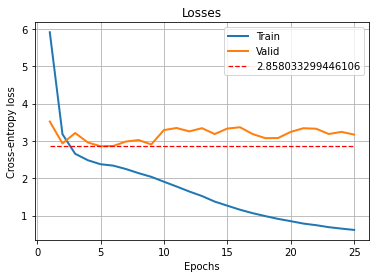

In [ ]:
plot_losses()

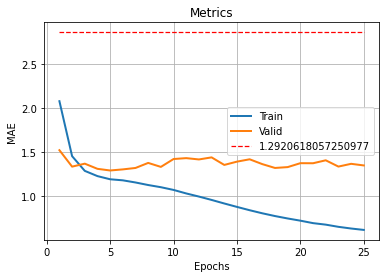

In [ ]:
plot_metrics()

# Experiments #4
Add Year-Of-Publication
Add book authors

In [ ]:
class BstTransformer(nn.Module):
    def __init__(
        self,
        books_num_unique,
        users_num_unique,
        authors_num_unique,
        pubs_num_unique,
        sequence_length=10,
        embedding_size=512,  
        num_transformer_layers=6,
        ratings_range=(1, 10),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        # Item embeddings
        self.books_embeddings = nn.Embedding(
            books_num_unique + 1, embedding_size, padding_idx=0
        )
        self.ratings_embeddings = nn.Embedding(11, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)
        self.author_embeddings = nn.Embedding(authors_num_unique, embedding_size) # TODO: EXPERIMENTS
        self.pub_embeddings = nn.Embedding(pubs_num_unique, embedding_size)
        # User embeddings
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.age_group_embeddings = nn.Embedding(8, 20)
        self.location_embeddings = nn.Embedding(3, 10)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=4,
                dim_feedforward=1024,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length) + 20 + 10,
                512,
            ),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Mish(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        user_id, book_ids, author_ids, previous_ratings, age_group, location, pubs, mask = inputs

        age_group = self.age_group_embeddings(age_group)
        user_id = self.user_embeddings(user_id)
        location = self.location_embeddings(location)

        # print(age_group.shape)
        user_features = torch.cat(
            (user_id, age_group, location), 1
        )
        # print(user_id.shape, age_group.shape)
        # print(user_features.shape)
        # print('=============================')
        book_history = book_ids[:, :-1]
        target_book = book_ids[:, -1]
        authors = author_ids[:, :-1]
        target_author = author_ids[:, -1]
        publications = pubs[:, :-1]
        target_pub = pubs[:, -1]

        ratings = self.ratings_embeddings(previous_ratings)
        encoded_books = self.books_embeddings(book_history)
        encoded_target_book = self.books_embeddings(target_book)
        authors = self.author_embeddings(authors)
        target_author = self.author_embeddings(target_author)
        publications = self.pub_embeddings(publications)
        target_pub = self.pub_embeddings(target_pub)

        positions = torch.arange(
            0,
            self.sequence_length - 1,
            1,
            dtype=int,
            device=book_ids.device,
        )
        positions = self.position_embeddings(positions)

        encoded_sequence_books_with_position_and_rating = (
            encoded_books + ratings + positions + authors + publications
        )
        # print(encoded_books.shape, ratings.shape, positions.shape)
        encoded_target_book = (encoded_target_book + target_author + target_pub).unsqueeze(1)
        # print(encoded_sequence_books_with_position_and_rating.shape, encoded_target_book.shape)
        transformer_features = torch.cat(
            (encoded_sequence_books_with_position_and_rating, encoded_target_book),
            dim=1,
        )
        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        # print(transformer_output.shape)
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        # print('=============================')

        combined_output = torch.cat((transformer_output, user_features), dim=1)
        # print(combined_output.shape)
        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]

In [ ]:
model = BstTransformer(
    len(book_lookup), len(user_lookup), len(author_lookup), len(publication_lookup), sequence_length, embedding_size=64
)
model = model.to(device)
loss_func = torch.nn.MSELoss()
mae_func = torchmetrics.MeanAbsoluteError()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    mae_metrics = 0
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        # print(batch)
        # print("===============================================")
        user_id, book_ids, author_ids, prev_ratings, age_group, location, pubs, mask, target_rating = batch
        # model.zero_grad()
        pred_rating = model((user_id, book_ids, author_ids, prev_ratings, age_group, location, pubs, mask))
        loss = loss_func(pred_rating, target_rating)
        total_loss += loss.item()
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = pred_rating.detach().cpu().numpy()
        mae_metrics += mae_func(pred_rating.detach().cpu(), target_rating.detach().cpu())
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    mae_metrics /= len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
        
    return avg_loss, mae_metrics, total_preds

def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    mae_metrics = 0

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        user_id, book_ids, author_ids, prev_ratings, age_group, location, pubs, mask, target_rating = batch
        with torch.no_grad():
            pred_rating = model((user_id, book_ids, author_ids, prev_ratings, age_group, location, pubs, mask))
            loss = loss_func(pred_rating, target_rating)
            total_loss = total_loss + loss.item()
            # mae_metrics += mae_func(pred_rating, taget_rating)
            preds = pred_rating.detach().cpu().numpy()
            mae_metrics += mae_func(pred_rating.detach().cpu(), target_rating.detach().cpu())
            # print(mae_metrics)
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    mae_metrics /= len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    return avg_loss, mae_metrics, total_preds

In [ ]:
all_train_losses = []
all_valid_losses = []
all_train_metrics = []
all_val_metrics = []
best_valid_loss = float('inf')
best_val_metric = float('inf')
epochs = 60
train_losses = []
valid_losses = []
train_metrics, val_metrics = [], []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, train_mae, _ = train()
    valid_loss, val_mae, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_metric = val_mae
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_metrics.append(train_mae)
    val_metrics.append(val_mae)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')
    print(f'Training MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    
all_train_losses.extend(train_losses)
all_valid_losses.extend(valid_losses)
all_train_metrics.extend(train_metrics)
all_val_metrics.extend(val_metrics)


 Epoch1 / 60


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]



Training loss: 9.623
Validation loss: 8.748
Training MAE: 2.7496774196624756
Validation MAE: 2.628390312194824

 Epoch2 / 60


100%|██████████| 2/2 [00:00<00:00,  5.09it/s]



Training loss: 8.999
Validation loss: 8.246
Training MAE: 2.6784396171569824
Validation MAE: 2.5505247116088867

 Epoch3 / 60


100%|██████████| 2/2 [00:00<00:00,  4.33it/s]



Training loss: 8.286
Validation loss: 7.094
Training MAE: 2.5535671710968018
Validation MAE: 2.338132858276367

 Epoch4 / 60


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]



Training loss: 6.606
Validation loss: 5.493
Training MAE: 2.227173328399658
Validation MAE: 2.027681827545166

 Epoch5 / 60


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]



Training loss: 5.483
Validation loss: 5.069
Training MAE: 2.008474588394165
Validation MAE: 1.920795202255249

 Epoch6 / 60


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]



Training loss: 4.965
Validation loss: 4.943
Training MAE: 1.9009110927581787
Validation MAE: 1.8960468769073486

 Epoch7 / 60


100%|██████████| 2/2 [00:00<00:00,  4.94it/s]



Training loss: 4.645
Validation loss: 4.586
Training MAE: 1.831587314605713
Validation MAE: 1.819040060043335

 Epoch8 / 60


100%|██████████| 2/2 [00:00<00:00,  5.25it/s]



Training loss: 4.406
Validation loss: 4.407
Training MAE: 1.7793185710906982
Validation MAE: 1.785191535949707

 Epoch9 / 60


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]



Training loss: 4.218
Validation loss: 4.242
Training MAE: 1.73550283908844
Validation MAE: 1.7353800535202026

 Epoch10 / 60


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]



Training loss: 4.051
Validation loss: 3.905
Training MAE: 1.6958820819854736
Validation MAE: 1.6563944816589355

 Epoch11 / 60


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]



Training loss: 3.909
Validation loss: 3.770
Training MAE: 1.6620014905929565
Validation MAE: 1.6275243759155273

 Epoch12 / 60


100%|██████████| 2/2 [00:00<00:00,  4.82it/s]



Training loss: 3.794
Validation loss: 3.843
Training MAE: 1.6308190822601318
Validation MAE: 1.632249116897583

 Epoch13 / 60


100%|██████████| 2/2 [00:00<00:00,  4.31it/s]



Training loss: 3.668
Validation loss: 3.783
Training MAE: 1.5985164642333984
Validation MAE: 1.6177992820739746

 Epoch14 / 60


100%|██████████| 2/2 [00:00<00:00,  3.99it/s]



Training loss: 3.579
Validation loss: 3.366
Training MAE: 1.5727070569992065
Validation MAE: 1.511927843093872

 Epoch15 / 60


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]



Training loss: 3.483
Validation loss: 3.274
Training MAE: 1.5481631755828857
Validation MAE: 1.4903650283813477

 Epoch16 / 60


100%|██████████| 2/2 [00:00<00:00,  4.27it/s]



Training loss: 3.388
Validation loss: 3.441
Training MAE: 1.5218812227249146
Validation MAE: 1.5172991752624512

 Epoch17 / 60


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]



Training loss: 3.310
Validation loss: 3.424
Training MAE: 1.5001388788223267
Validation MAE: 1.5056025981903076

 Epoch18 / 60


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]



Training loss: 3.235
Validation loss: 3.201
Training MAE: 1.4780442714691162
Validation MAE: 1.4745268821716309

 Epoch19 / 60


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]



Training loss: 3.166
Validation loss: 3.319
Training MAE: 1.4607571363449097
Validation MAE: 1.480484962463379

 Epoch20 / 60


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]



Training loss: 3.108
Validation loss: 3.291
Training MAE: 1.441831111907959
Validation MAE: 1.4704170227050781

 Epoch21 / 60


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]



Training loss: 3.050
Validation loss: 3.194
Training MAE: 1.4241423606872559
Validation MAE: 1.4535255432128906

 Epoch22 / 60


100%|██████████| 2/2 [00:00<00:00,  4.34it/s]



Training loss: 2.987
Validation loss: 3.140
Training MAE: 1.4067585468292236
Validation MAE: 1.4242379665374756

 Epoch23 / 60


100%|██████████| 2/2 [00:00<00:00,  4.42it/s]



Training loss: 2.948
Validation loss: 2.943
Training MAE: 1.3953793048858643
Validation MAE: 1.3717081546783447

 Epoch24 / 60


100%|██████████| 2/2 [00:00<00:00,  4.27it/s]



Training loss: 2.899
Validation loss: 3.067
Training MAE: 1.376560926437378
Validation MAE: 1.4010809659957886

 Epoch25 / 60


100%|██████████| 2/2 [00:00<00:00,  5.15it/s]



Training loss: 2.858
Validation loss: 3.064
Training MAE: 1.366470456123352
Validation MAE: 1.3937439918518066

 Epoch26 / 60


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]



Training loss: 2.815
Validation loss: 2.837
Training MAE: 1.35554039478302
Validation MAE: 1.356129765510559

 Epoch27 / 60


100%|██████████| 2/2 [00:00<00:00,  5.18it/s]



Training loss: 2.768
Validation loss: 3.145
Training MAE: 1.3420116901397705
Validation MAE: 1.3872926235198975

 Epoch28 / 60


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]



Training loss: 2.727
Validation loss: 3.104
Training MAE: 1.3293043375015259
Validation MAE: 1.4010345935821533

 Epoch29 / 60


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]



Training loss: 2.700
Validation loss: 3.008
Training MAE: 1.3186589479446411
Validation MAE: 1.370671033859253

 Epoch30 / 60


100%|██████████| 2/2 [00:00<00:00,  4.84it/s]



Training loss: 2.673
Validation loss: 3.134
Training MAE: 1.3108865022659302
Validation MAE: 1.3791115283966064

 Epoch31 / 60


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]



Training loss: 2.638
Validation loss: 2.802
Training MAE: 1.2987524271011353
Validation MAE: 1.3291325569152832

 Epoch32 / 60


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]



Training loss: 2.616
Validation loss: 2.985
Training MAE: 1.2886216640472412
Validation MAE: 1.3576076030731201

 Epoch33 / 60


100%|██████████| 2/2 [00:00<00:00,  5.04it/s]



Training loss: 2.594
Validation loss: 2.936
Training MAE: 1.2814257144927979
Validation MAE: 1.3292593955993652

 Epoch34 / 60


100%|██████████| 2/2 [00:00<00:00,  5.23it/s]



Training loss: 2.555
Validation loss: 2.830
Training MAE: 1.2730680704116821
Validation MAE: 1.3117125034332275

 Epoch35 / 60


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]



Training loss: 2.553
Validation loss: 2.977
Training MAE: 1.2677913904190063
Validation MAE: 1.332858681678772

 Epoch36 / 60


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]



Training loss: 2.528
Validation loss: 2.902
Training MAE: 1.2581499814987183
Validation MAE: 1.3315352201461792

 Epoch37 / 60


100%|██████████| 2/2 [00:00<00:00,  5.17it/s]



Training loss: 2.544
Validation loss: 2.927
Training MAE: 1.2615655660629272
Validation MAE: 1.3371968269348145

 Epoch38 / 60


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]



Training loss: 2.483
Validation loss: 3.227
Training MAE: 1.2437599897384644
Validation MAE: 1.369370698928833

 Epoch39 / 60


100%|██████████| 2/2 [00:00<00:00,  3.46it/s]



Training loss: 2.476
Validation loss: 2.793
Training MAE: 1.2390936613082886
Validation MAE: 1.289541244506836

 Epoch40 / 60


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]



Training loss: 2.464
Validation loss: 2.902
Training MAE: 1.2338745594024658
Validation MAE: 1.3066785335540771

 Epoch41 / 60


100%|██████████| 2/2 [00:00<00:00,  3.69it/s]



Training loss: 2.521
Validation loss: 2.702
Training MAE: 1.2473547458648682
Validation MAE: 1.2943222522735596

 Epoch42 / 60


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]



Training loss: 2.515
Validation loss: 2.901
Training MAE: 1.2401938438415527
Validation MAE: 1.3003685474395752

 Epoch43 / 60


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]



Training loss: 2.467
Validation loss: 3.007
Training MAE: 1.22959303855896
Validation MAE: 1.3291277885437012

 Epoch44 / 60


100%|██████████| 2/2 [00:00<00:00,  4.28it/s]



Training loss: 2.551
Validation loss: 2.812
Training MAE: 1.2469950914382935
Validation MAE: 1.3030081987380981

 Epoch45 / 60


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]



Training loss: 2.471
Validation loss: 2.722
Training MAE: 1.227574110031128
Validation MAE: 1.2787740230560303

 Epoch46 / 60


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]



Training loss: 2.410
Validation loss: 2.691
Training MAE: 1.2112220525741577
Validation MAE: 1.2709592580795288

 Epoch47 / 60


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]



Training loss: 2.480
Validation loss: 2.993
Training MAE: 1.2258888483047485
Validation MAE: 1.3129899501800537

 Epoch48 / 60


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]



Training loss: 2.516
Validation loss: 2.789
Training MAE: 1.233891248703003
Validation MAE: 1.2818896770477295

 Epoch49 / 60


100%|██████████| 2/2 [00:00<00:00,  4.50it/s]



Training loss: 2.479
Validation loss: 2.790
Training MAE: 1.2274333238601685
Validation MAE: 1.2874128818511963

 Epoch50 / 60


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]



Training loss: 2.522
Validation loss: 2.810
Training MAE: 1.2344588041305542
Validation MAE: 1.2934272289276123

 Epoch51 / 60


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]



Training loss: 2.461
Validation loss: 2.889
Training MAE: 1.2163989543914795
Validation MAE: 1.3065898418426514

 Epoch52 / 60


100%|██████████| 2/2 [00:00<00:00,  4.51it/s]



Training loss: 2.363
Validation loss: 2.813
Training MAE: 1.1936992406845093
Validation MAE: 1.271571397781372

 Epoch53 / 60


100%|██████████| 2/2 [00:00<00:00,  5.16it/s]



Training loss: 2.409
Validation loss: 2.879
Training MAE: 1.2014219760894775
Validation MAE: 1.2805958986282349

 Epoch54 / 60


100%|██████████| 2/2 [00:00<00:00,  4.25it/s]



Training loss: 2.431
Validation loss: 2.873
Training MAE: 1.2077172994613647
Validation MAE: 1.3012773990631104

 Epoch55 / 60


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]



Training loss: 2.369
Validation loss: 2.832
Training MAE: 1.191534161567688
Validation MAE: 1.2886114120483398

 Epoch56 / 60


100%|██████████| 2/2 [00:00<00:00,  4.61it/s]



Training loss: 2.485
Validation loss: 2.915
Training MAE: 1.2181559801101685
Validation MAE: 1.3084772825241089

 Epoch57 / 60


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]



Training loss: 2.364
Validation loss: 3.024
Training MAE: 1.1879634857177734
Validation MAE: 1.3047075271606445

 Epoch58 / 60


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]



Training loss: 2.623
Validation loss: 2.884
Training MAE: 1.255264401435852
Validation MAE: 1.3095874786376953

 Epoch59 / 60


100%|██████████| 2/2 [00:00<00:00,  4.96it/s]



Training loss: 2.362
Validation loss: 2.762
Training MAE: 1.1873149871826172
Validation MAE: 1.2769744396209717

 Epoch60 / 60


100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


Training loss: 2.449
Validation loss: 2.773
Training MAE: 1.2117111682891846
Validation MAE: 1.2899622917175293


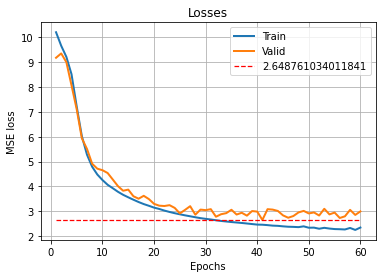

In [ ]:
# embed_size = 60, num_layers=3, nhead=10, lr=1e-5
plot_losses()

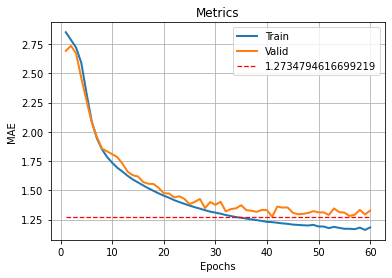

In [ ]:
plot_metrics()

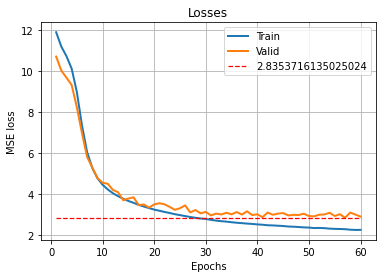

In [ ]:
# embed_size=60, num_layers=2, nhead=12, lr=1e-5
plot_losses()

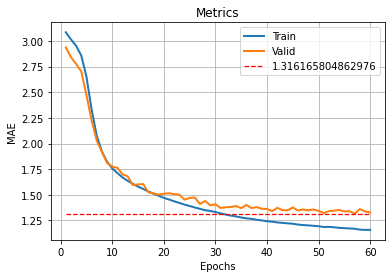

In [ ]:
plot_metrics()

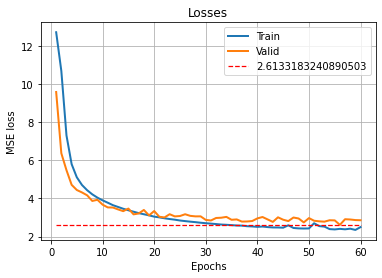

In [ ]:
# embed_size=60, num_layers=6, nhead=4, lr=1e-5
plot_losses()

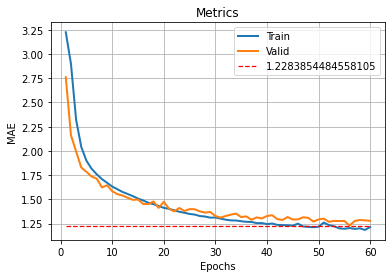

In [ ]:
plot_metrics()

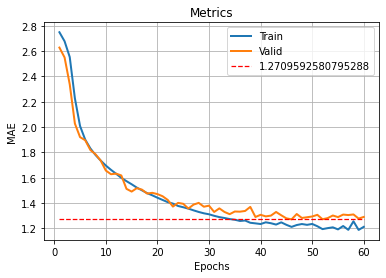

In [ ]:
# retrain to save weigths
plot_metrics()

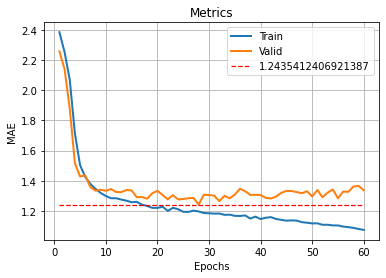

In [ ]:
# best params, lr=2e-5
plot_metrics()

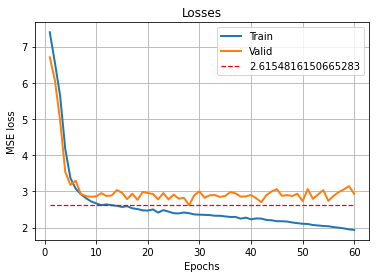

In [ ]:
plot_losses()

# Recommender System


In [ ]:
from random import randint

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/Diploma/saved_weights.pt"
# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
user_data = seq_with_user_features[seq_with_user_features.user_id=='496'].iloc[4]
user_data

user_id                                                              496
Book_title             ([PAD], [PAD], [PAD], [PAD], [PAD], Something ...
Book_Author            ([PAD], [PAD], [PAD], [PAD], [PAD], Jean Chris...
time                   ([PAD], [PAD], [PAD], [PAD], [PAD], 10089, 100...
is_valid                                                           False
Year-Of-Publication    ([PAD], [PAD], [PAD], [PAD], [PAD], 2000, 1983...
target_rating                                                        7.0
previous_ratings       ([PAD], [PAD], [PAD], [PAD], [PAD], 7.0, 8.0, ...
pad_mask               [True, True, True, True, True, False, False, F...
num_pads                                                               5
Location                                      west fairlee, vermont, usa
Age                                                                   43
age_encoded                                                            4
location_encoded                                   

In [ ]:
whole_dataset = BookSequenceDataset(seq_with_user_features, book_lookup, user_lookup, author_lookup, publication_lookup)

In [ ]:
def generate_test_input(num_users=100):
  active_users = set()
  taken_rows = []
  taken_target_items = []
  sorted_ratings_df = ratings_df.sort_values(by='time').reset_index()
  index = sorted_ratings_df.index
  for i in range(num_users):
    rand = randint(0, len(user_lookup)-1)
    while rand in active_users:
      rand = randint(0, len(user_lookup)-1)
    active_users.add(rand)
    user = list(user_lookup.keys())[rand]
    user_rows = index[sorted_ratings_df.user_id==user]
    active_rows = set()
    for i in range(10):
      while True:
        row = randint(user_rows[0], user_rows[-1])
        if row not in active_rows:
          active_rows.add(row)
          break
      taken_rows.append(row)
    taken_target_items.append(sorted_ratings_df.iloc[taken_rows[-1]].book_id)
  test_df = sorted_ratings_df.iloc[taken_rows].sort_values(by='time').groupby('user_id').agg(tuple).reset_index()
  # test_dataset = BookSequenceDataset(test_df, book_lookup, user_lookup, author_lookup, publication_lookup)
  # test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset))
  return test_df, active_users, taken_target_items

In [ ]:
test_grouped_ratings, taken_users, taken_items = generate_test_input(1000)
print(len(test_grouped_ratings.user_id.unique()))
test_grouped_ratings.head()

1000


,user_id,index,book_id,Book_title,Book_Author,time,rating,Year-Of-Publication,is_valid
0,1,"(34, 115, 120, 191, 208, 270, 386, 516, 676, 752)","(202, 4810, 6251, 1514, 2566, 1714, 2955, 5988...",(What a Wonderful World: A Lifetime of Recordi...,"(Bob Thiele, Carole Mortimer, Joan Walsh Anglu...","(3, 5, 6, 15, 16, 17, 19, 22, 29, 31)","(9.0, 5.0, 9.0, 9.0, 9.0, 9.0, 9.0, 6.0, 8.0, ...","(1995, 2002, 1997, 1998, 2000, 1994, 1998, 199...","(False, False, False, False, False, False, Fal..."
1,1002,"(48832, 6013, 45818, 49130, 4858, 40599, 17449...","(6952, 1290, 628, 13972, 1863, 2231, 1722, 32,...",(Bride of Dark and Stormy: Yet More of the Bes...,"(Scott Rice, James Herriot, J. R. R. Tolkien, ...","(20860, 20862, 20864, 20866, 20867, 20871, 208...","(8.0, 7.0, 6.0, 4.0, 8.0, 10.0, 4.0, 7.0, 7.0,...","(1988, 1982, 1992, 1989, 1990, 1989, 2000, 199...","(False, False, False, False, False, False, Fal..."
2,1003,"(52328, 52549, 52609, 49864, 52896, 31244, 400...","(3932, 15989, 3602, 17149, 11574, 13582, 12314...","(Wild Orchids, The Light of Falling Stars, Don...","(Karen Robards, J. Robert Lennon, Amanda Quick...","(20922, 21150, 21184, 21202, 21453, 21456, 214...","(10.0, 10.0, 8.0, 9.0, 9.0, 5.0, 9.0, 9.0, 10....","(1986, 1998, 2003, 2001, 1994, 1998, 2000, 199...","(False, False, False, False, False, False, Fal..."
3,1004,"(1006, 53443, 31345, 25127, 45018, 43241, 2398...","(44, 16634, 1085, 9668, 2180, 15645, 2609, 192...",(El Senor De Los Anillos: LA Comunidad Del Ani...,"(J. R. R. Tolkien, Brendan Dubois, Stephen Kin...","(21975, 21977, 21983, 21986, 21987, 21991, 219...","(7.0, 10.0, 10.0, 9.0, 9.0, 10.0, 4.0, 10.0, 8...","(2001, 1995, 1988, 2000, 0, 1999, 1995, 1986, ...","(False, False, False, False, False, False, Fal..."
4,1005,"(30486, 32416, 49501, 15854, 52771, 40409, 283...","(2821, 8068, 6400, 2004, 12828, 14963, 11244, ...","(The Polished Hoe, Sacred Trust, Travels aroun...","(Austin Clarke, Meg O'Brien, Harrison Evans Sa...","(22014, 22022, 22024, 22026, 22030, 22040, 220...","(9.0, 6.0, 7.0, 5.0, 8.0, 7.0, 10.0, 10.0, 8.0...","(2003, 2000, 1976, 2000, 1997, 1986, 1995, 199...","(False, False, False, False, False, False, Fal..."


In [ ]:
len(taken_users), len(taken_items)

(1000, 1000)

In [ ]:
test_grouped_ratings['num_ratings'] = grouped_ratings['rating'].apply(lambda row: len(row))
test_grouped_ratings.drop('index', inplace=True, axis=1)
test_grouped_ratings.head()

,user_id,book_id,Book_title,Book_Author,time,rating,Year-Of-Publication,is_valid,num_ratings
0,1,"(202, 4810, 6251, 1514, 2566, 1714, 2955, 5988...",(What a Wonderful World: A Lifetime of Recordi...,"(Bob Thiele, Carole Mortimer, Joan Walsh Anglu...","(3, 5, 6, 15, 16, 17, 19, 22, 29, 31)","(9.0, 5.0, 9.0, 9.0, 9.0, 9.0, 9.0, 6.0, 8.0, ...","(1995, 2002, 1997, 1998, 2000, 1994, 1998, 199...","(False, False, False, False, False, False, Fal...",32
1,1002,"(6952, 1290, 628, 13972, 1863, 2231, 1722, 32,...",(Bride of Dark and Stormy: Yet More of the Bes...,"(Scott Rice, James Herriot, J. R. R. Tolkien, ...","(20860, 20862, 20864, 20866, 20867, 20871, 208...","(8.0, 7.0, 6.0, 4.0, 8.0, 10.0, 4.0, 7.0, 7.0,...","(1988, 1982, 1992, 1989, 1990, 1989, 2000, 199...","(False, False, False, False, False, False, Fal...",22
2,1003,"(3932, 15989, 3602, 17149, 11574, 13582, 12314...","(Wild Orchids, The Light of Falling Stars, Don...","(Karen Robards, J. Robert Lennon, Amanda Quick...","(20922, 21150, 21184, 21202, 21453, 21456, 214...","(10.0, 10.0, 8.0, 9.0, 9.0, 5.0, 9.0, 9.0, 10....","(1986, 1998, 2003, 2001, 1994, 1998, 2000, 199...","(False, False, False, False, False, False, Fal...",1092
3,1004,"(44, 16634, 1085, 9668, 2180, 15645, 2609, 192...",(El Senor De Los Anillos: LA Comunidad Del Ani...,"(J. R. R. Tolkien, Brendan Dubois, Stephen Kin...","(21975, 21977, 21983, 21986, 21987, 21991, 219...","(7.0, 10.0, 10.0, 9.0, 9.0, 10.0, 4.0, 10.0, 8...","(2001, 1995, 1988, 2000, 0, 1999, 1995, 1986, ...","(False, False, False, False, False, False, Fal...",32
4,1005,"(2821, 8068, 6400, 2004, 12828, 14963, 11244, ...","(The Polished Hoe, Sacred Trust, Travels aroun...","(Austin Clarke, Meg O'Brien, Harrison Evans Sa...","(22014, 22022, 22024, 22026, 22030, 22040, 220...","(9.0, 6.0, 7.0, 5.0, 8.0, 7.0, 10.0, 10.0, 8.0...","(2003, 2000, 1976, 2000, 1997, 1986, 1995, 199...","(False, False, False, False, False, False, Fal...",50


In [ ]:
test_grouped_ratings['target_rating'] = test_grouped_ratings['rating'].apply(get_last_entry)
test_grouped_ratings['previous_ratings'] = test_grouped_ratings['rating'].apply(lambda seq: seq[:-1])
test_grouped_ratings.drop(columns=['rating'], inplace=True)
test_grouped_ratings.head()

,user_id,book_id,Book_title,Book_Author,time,Year-Of-Publication,is_valid,num_ratings,target_rating,previous_ratings
0,1,"(202, 4810, 6251, 1514, 2566, 1714, 2955, 5988...",(What a Wonderful World: A Lifetime of Recordi...,"(Bob Thiele, Carole Mortimer, Joan Walsh Anglu...","(3, 5, 6, 15, 16, 17, 19, 22, 29, 31)","(1995, 2002, 1997, 1998, 2000, 1994, 1998, 199...","(False, False, False, False, False, False, Fal...",32,8.0,"(9.0, 5.0, 9.0, 9.0, 9.0, 9.0, 9.0, 6.0, 8.0)"
1,1002,"(6952, 1290, 628, 13972, 1863, 2231, 1722, 32,...",(Bride of Dark and Stormy: Yet More of the Bes...,"(Scott Rice, James Herriot, J. R. R. Tolkien, ...","(20860, 20862, 20864, 20866, 20867, 20871, 208...","(1988, 1982, 1992, 1989, 1990, 1989, 2000, 199...","(False, False, False, False, False, False, Fal...",22,10.0,"(8.0, 7.0, 6.0, 4.0, 8.0, 10.0, 4.0, 7.0, 7.0)"
2,1003,"(3932, 15989, 3602, 17149, 11574, 13582, 12314...","(Wild Orchids, The Light of Falling Stars, Don...","(Karen Robards, J. Robert Lennon, Amanda Quick...","(20922, 21150, 21184, 21202, 21453, 21456, 214...","(1986, 1998, 2003, 2001, 1994, 1998, 2000, 199...","(False, False, False, False, False, False, Fal...",1092,10.0,"(10.0, 10.0, 8.0, 9.0, 9.0, 5.0, 9.0, 9.0, 10.0)"
3,1004,"(44, 16634, 1085, 9668, 2180, 15645, 2609, 192...",(El Senor De Los Anillos: LA Comunidad Del Ani...,"(J. R. R. Tolkien, Brendan Dubois, Stephen Kin...","(21975, 21977, 21983, 21986, 21987, 21991, 219...","(2001, 1995, 1988, 2000, 0, 1999, 1995, 1986, ...","(False, False, False, False, False, False, Fal...",32,10.0,"(7.0, 10.0, 10.0, 9.0, 9.0, 10.0, 4.0, 10.0, 8.0)"
4,1005,"(2821, 8068, 6400, 2004, 12828, 14963, 11244, ...","(The Polished Hoe, Sacred Trust, Travels aroun...","(Austin Clarke, Meg O'Brien, Harrison Evans Sa...","(22014, 22022, 22024, 22026, 22030, 22040, 220...","(2003, 2000, 1976, 2000, 1997, 1986, 1995, 199...","(False, False, False, False, False, False, Fal...",50,10.0,"(9.0, 6.0, 7.0, 5.0, 8.0, 7.0, 10.0, 10.0, 8.0)"


In [ ]:
test_grouped_ratings['pad_mask'] = test_grouped_ratings['Book_title'].apply(lambda x: (np.array(x) == '[PAD]'))
test_grouped_ratings['num_pads'] = test_grouped_ratings['pad_mask'].apply(sum)
test_grouped_ratings['pad_mask'] = test_grouped_ratings['pad_mask'].apply(lambda x: x.tolist()) # in case we serialize later
test_grouped_ratings.head()

,user_id,book_id,Book_title,Book_Author,time,Year-Of-Publication,is_valid,num_ratings,target_rating,previous_ratings,pad_mask,num_pads
0,1,"(202, 4810, 6251, 1514, 2566, 1714, 2955, 5988...",(What a Wonderful World: A Lifetime of Recordi...,"(Bob Thiele, Carole Mortimer, Joan Walsh Anglu...","(3, 5, 6, 15, 16, 17, 19, 22, 29, 31)","(1995, 2002, 1997, 1998, 2000, 1994, 1998, 199...","(False, False, False, False, False, False, Fal...",32,8.0,"(9.0, 5.0, 9.0, 9.0, 9.0, 9.0, 9.0, 6.0, 8.0)","[False, False, False, False, False, False, Fal...",0
1,1002,"(6952, 1290, 628, 13972, 1863, 2231, 1722, 32,...",(Bride of Dark and Stormy: Yet More of the Bes...,"(Scott Rice, James Herriot, J. R. R. Tolkien, ...","(20860, 20862, 20864, 20866, 20867, 20871, 208...","(1988, 1982, 1992, 1989, 1990, 1989, 2000, 199...","(False, False, False, False, False, False, Fal...",22,10.0,"(8.0, 7.0, 6.0, 4.0, 8.0, 10.0, 4.0, 7.0, 7.0)","[False, False, False, False, False, False, Fal...",0
2,1003,"(3932, 15989, 3602, 17149, 11574, 13582, 12314...","(Wild Orchids, The Light of Falling Stars, Don...","(Karen Robards, J. Robert Lennon, Amanda Quick...","(20922, 21150, 21184, 21202, 21453, 21456, 214...","(1986, 1998, 2003, 2001, 1994, 1998, 2000, 199...","(False, False, False, False, False, False, Fal...",1092,10.0,"(10.0, 10.0, 8.0, 9.0, 9.0, 5.0, 9.0, 9.0, 10.0)","[False, False, False, False, False, False, Fal...",0
3,1004,"(44, 16634, 1085, 9668, 2180, 15645, 2609, 192...",(El Senor De Los Anillos: LA Comunidad Del Ani...,"(J. R. R. Tolkien, Brendan Dubois, Stephen Kin...","(21975, 21977, 21983, 21986, 21987, 21991, 219...","(2001, 1995, 1988, 2000, 0, 1999, 1995, 1986, ...","(False, False, False, False, False, False, Fal...",32,10.0,"(7.0, 10.0, 10.0, 9.0, 9.0, 10.0, 4.0, 10.0, 8.0)","[False, False, False, False, False, False, Fal...",0
4,1005,"(2821, 8068, 6400, 2004, 12828, 14963, 11244, ...","(The Polished Hoe, Sacred Trust, Travels aroun...","(Austin Clarke, Meg O'Brien, Harrison Evans Sa...","(22014, 22022, 22024, 22026, 22030, 22040, 220...","(2003, 2000, 1976, 2000, 1997, 1986, 1995, 199...","(False, False, False, False, False, False, Fal...",50,10.0,"(9.0, 6.0, 7.0, 5.0, 8.0, 7.0, 10.0, 10.0, 8.0)","[False, False, False, False, False, False, Fal...",0


In [ ]:
test_grouped_ratings = pd.merge(test_grouped_ratings, users_info)
test_grouped_ratings.head()

,user_id,book_id,Book_title,Book_Author,time,Year-Of-Publication,is_valid,num_ratings,target_rating,previous_ratings,pad_mask,num_pads,Location,Age,age_encoded,location_encoded
0,1,"(202, 4810, 6251, 1514, 2566, 1714, 2955, 5988...",(What a Wonderful World: A Lifetime of Recordi...,"(Bob Thiele, Carole Mortimer, Joan Walsh Anglu...","(3, 5, 6, 15, 16, 17, 19, 22, 29, 31)","(1995, 2002, 1997, 1998, 2000, 1994, 1998, 199...","(False, False, False, False, False, False, Fal...",32,8.0,"(9.0, 5.0, 9.0, 9.0, 9.0, 9.0, 9.0, 6.0, 8.0)","[False, False, False, False, False, False, Fal...",0,"minneapolis, minnesota, usa",24,2,2
1,1002,"(6952, 1290, 628, 13972, 1863, 2231, 1722, 32,...",(Bride of Dark and Stormy: Yet More of the Bes...,"(Scott Rice, James Herriot, J. R. R. Tolkien, ...","(20860, 20862, 20864, 20866, 20867, 20871, 208...","(1988, 1982, 1992, 1989, 1990, 1989, 2000, 199...","(False, False, False, False, False, False, Fal...",22,10.0,"(8.0, 7.0, 6.0, 4.0, 8.0, 10.0, 4.0, 7.0, 7.0)","[False, False, False, False, False, False, Fal...",0,"west blocton, alabama, usa",45,4,2
2,1003,"(3932, 15989, 3602, 17149, 11574, 13582, 12314...","(Wild Orchids, The Light of Falling Stars, Don...","(Karen Robards, J. Robert Lennon, Amanda Quick...","(20922, 21150, 21184, 21202, 21453, 21456, 214...","(1986, 1998, 2003, 2001, 1994, 1998, 2000, 199...","(False, False, False, False, False, False, Fal...",1092,10.0,"(10.0, 10.0, 8.0, 9.0, 9.0, 5.0, 9.0, 9.0, 10.0)","[False, False, False, False, False, False, Fal...",0,"morrow, georgia, usa",52,5,2
3,1004,"(44, 16634, 1085, 9668, 2180, 15645, 2609, 192...",(El Senor De Los Anillos: LA Comunidad Del Ani...,"(J. R. R. Tolkien, Brendan Dubois, Stephen Kin...","(21975, 21977, 21983, 21986, 21987, 21991, 219...","(2001, 1995, 1988, 2000, 0, 1999, 1995, 1986, ...","(False, False, False, False, False, False, Fal...",32,10.0,"(7.0, 10.0, 10.0, 9.0, 9.0, 10.0, 4.0, 10.0, 8.0)","[False, False, False, False, False, False, Fal...",0,"yuma, arizona, usa",17,1,2
4,1005,"(2821, 8068, 6400, 2004, 12828, 14963, 11244, ...","(The Polished Hoe, Sacred Trust, Travels aroun...","(Austin Clarke, Meg O'Brien, Harrison Evans Sa...","(22014, 22022, 22024, 22026, 22030, 22040, 220...","(2003, 2000, 1976, 2000, 1997, 1986, 1995, 199...","(False, False, False, False, False, False, Fal...",50,10.0,"(9.0, 6.0, 7.0, 5.0, 8.0, 7.0, 10.0, 10.0, 8.0)","[False, False, False, False, False, False, Fal...",0,"columbia, south carolina, usa",43,4,2


In [ ]:
test_dataset = BookSequenceDataset(test_grouped_ratings, book_lookup, user_lookup, author_lookup, publication_lookup)
print(len(test_dataset))

1000


In [ ]:
# train_data = TensorDataset(train_dataset, train_mask, train_y)
test_sampler = RandomSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler = test_sampler, batch_size = 1000)

In [ ]:
def generate_test_df():
  test_grouped_ratings = generate_test_input(1000)
  test_grouped_ratings['num_ratings'] = grouped_ratings['rating'].apply(lambda row: len(row))
  test_grouped_ratings.drop('index', inplace=True, axis=1)
  test_grouped_ratings['target_rating'] = test_grouped_ratings['rating'].apply(get_last_entry)
  test_grouped_ratings['previous_ratings'] = test_grouped_ratings['rating'].apply(lambda seq: seq[:-1])
  test_grouped_ratings.drop(columns=['rating'], inplace=True)
  test_grouped_ratings['pad_mask'] = test_grouped_ratings['Book_title'].apply(lambda x: (np.array(x) == '[PAD]'))
  test_grouped_ratings['num_pads'] = test_grouped_ratings['pad_mask'].apply(sum)
  test_grouped_ratings['pad_mask'] = test_grouped_ratings['pad_mask'].apply(lambda x: x.tolist()) # in case we serialize later
  test_grouped_ratings = pd.merge(test_grouped_ratings, users_info)
  test_dataset = BookSequenceDataset(test_grouped_ratings, book_lookup, user_lookup, author_lookup, publication_lookup)
  print(len(test_dataset))
  test_sampler = RandomSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler = test_sampler, batch_size = 1000)

In [ ]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [ ]:
def get_actual_relevant_items(df, lower):
  ids = df.index
  relevant_ids = ids[df.target_rating > lower]
  return df.iloc[relevant_ids].Book_title.apply(lambda x: x[-1])

In [ ]:
def plot_mapk():
  # make data
  x = np.arange(5, 20, 1)
  # plot
  fig, ax = plt.subplots()

  ax.plot(x, mapk_metrics, linewidth=2.0, label="Test")

  plt.grid()
  plt.title("AP@K Metric")
  plt.xlabel("Param k")
  plt.ylabel("Average Precision")
  ax.legend()
  plt.show()

In [ ]:
relevant_books = list(get_actual_relevant_items(test_grouped_ratings, 8))

In [ ]:
for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
    batch = [r.to(device) for r in batch]
    user_id, book_ids, author_ids, prev_ratings, age_group, location, pubs, mask, target_rating = batch
    
    book_names = list(book_lookup.keys())
    pred_books = list()
    pred_rating = model((user_id, book_ids, author_ids, prev_ratings, age_group, location, pubs, mask))
    for i, rate in enumerate(pred_rating):
      if rate > 8:
        pred_books.append((book_names[book_ids[i][-1] - 1], rate))
    pred_books.sort(key=lambda x: x[1], reverse=True)
    for i in range(len(pred_books)):
      pred_books[i] = pred_books[i][0]

    mapk_metrics = []
    for i in range(5, 20, 1):
      prec = mapk([relevant_books], [pred_books], i)
      mapk_metrics.append(prec)

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


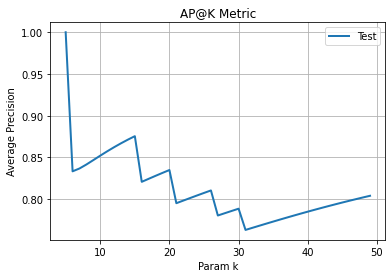

In [ ]:
plot_mapk()

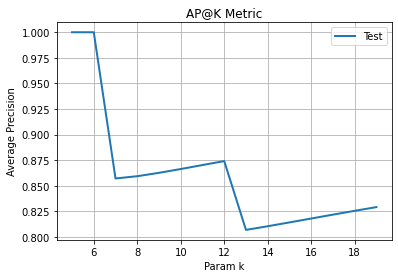

In [ ]:
plot_mapk()

In [ ]:
valid_seq_df_rs = valid_seq_df.reset_index()
valid_seq_df_rs

,index,user_id,Book_title,Book_Author,time,is_valid,Year-Of-Publication,target_rating,previous_ratings,pad_mask,num_pads
0,31,1,"(Canine Crimes, Little Women (Signet Classic),...","(Jeffrey Marks, Louisa May Alcott, Gloria Nayl...","(22, 23, 24, 25, 26, 27, 28, 29, 30, 31)",True,"(1998, 1988, 1989, 2001, 1998, 1996, 1999, 199...",8.0,"(6.0, 7.0, 9.0, 8.0, 8.0, 9.0, 9.0, 8.0, 7.0)","[False, False, False, False, False, False, Fal...",0
1,53,1002,(Nightmare in Shining Armor : A Den of Antiqui...,"(Tamar Myers, Paul Auster, Jane R. Bicks, Dian...","(20872, 20873, 20874, 20875, 20876, 20877, 208...",True,"(2001, 2000, 1999, 1994, 1989, 1998, 1997, 199...",10.0,"(6.0, 4.0, 8.0, 5.0, 2.0, 7.0, 7.0, 8.0, 8.0)","[False, False, False, False, False, False, Fal...",0
2,1145,1003,"(One for the Money (A Stephanie Plum Novel), A...","(Janet Evanovich, Julian, Lisa Plumley, W.P. K...","(21964, 21965, 21966, 21967, 21968, 21969, 219...",True,"(2003, 1995, 2002, 1990, 1983, 1989, 1996, 200...",9.0,"(8.0, 8.0, 5.0, 9.0, 9.0, 9.0, 10.0, 9.0, 10.0)","[False, False, False, False, False, False, Fal...",0
3,1177,1004,(The Talismans of Shannara (Heritage of Shanna...,"(Terry Brooks, Terry Pratchett, John Grisham, ...","(21996, 21997, 21998, 21999, 22000, 22001, 220...",True,"(1994, 1997, 1995, 1986, 1999, 1996, 2000, 199...",10.0,"(10.0, 7.0, 4.0, 10.0, 9.0, 8.0, 7.0, 10.0, 10.0)","[False, False, False, False, False, False, Fal...",0
4,1227,1005,"(Nothing but Velvet, Rogue'S Return (Harlequin...","(Kat Martin, Molly Moore, Anne Knoll, Connie W...","(22046, 22047, 22048, 22049, 22050, 22051, 220...",True,"(1997, 1997, 2002, 1998, 1997, 2003, 2004, 200...",10.0,"(8.0, 8.0, 8.0, 5.0, 8.0, 8.0, 8.0, 10.0, 4.0)","[False, False, False, False, False, False, Fal...",0
...,...,...,...,...,...,...,...,...,...,...,...
1290,62516,99,"(They Went Whistling : Women Wayfarers, Warrio...","(Barbara Holland, Joe Hutsko, Anne Rice, Jane ...","(1964, 1965, 1966, 1967, 1968, 1969, 1970, 197...",True,"(2001, 2000, 1998, 1996, 1999, 1982, 1988, 199...",8.0,"(6.0, 8.0, 9.0, 8.0, 10.0, 8.0, 7.0, 8.0, 9.0)","[False, False, False, False, False, False, Fal...",0
1291,62537,990,"(The Reality Dysfunction Part I: Emergence, Th...","(Peter F. Hamilton, Katharine C. Giovanni, Rob...","(20732, 20733, 20734, 20735, 20736, 20737, 207...",True,"(1997, 2002, 1995, 1978, 1986, 2003, 1996, 200...",9.0,"(10.0, 10.0, 9.0, 10.0, 8.0, 10.0, 10.0, 9.0, ...","[False, False, False, False, False, False, Fal...",0
1292,62564,991,(Tod am Zollhaus. Ein historischer Kriminalrom...,"(Petra Oelker, Emile Ajar, Angela Thirkell, Ch...","(20759, 20760, 20761, 20762, 20763, 20764, 207...",True,"(1997, 1978, 1994, 1991, 0, 1997, 1989, 1999, ...",8.0,"(9.0, 9.0, 8.0, 8.0, 7.0, 9.0, 8.0, 8.0, 8.0)","[False, False, False, False, False, False, Fal...",0
1293,62623,995,"(The Kiss, Arcadia, The Courage to Give: Inspi...","(Danielle Steel, Tom Stoppard, Jackie Waldman,...","(20818, 20819, 20820, 20821, 20822, 20823, 208...",True,"(2001, 1993, 1999, 2002, 2002, 1998, 2003, 200...",6.0,"(6.0, 8.0, 5.0, 3.0, 7.0, 8.0, 6.0, 9.0, 8.0)","[False, False, False, False, False, False, Fal...",0


In [ ]:
relevant_books_val = list(get_actual_relevant_items(valid_seq_df_rs, 8))
print(len(relevant_books_val))

In [ ]:
val_sampler = RandomSampler(val_dataset) # SequentialSampler(val_data)
val_dataloader_rs = DataLoader(val_dataset, sampler = val_sampler, batch_size = len(val_dataset))

# Imported RecSys

In [ ]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 9.9 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705361 sha256=f9ab7c8d6922cdca0f918994291e1d0b38682407c788ac85b2d47a16bb87cd31
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.special import expit
import pickle
import csv
import copy
import itertools
from lightfm import LightFM
import lightfm.evaluation
import sys
sys.path.append('../')
from sklearn.preprocessing import OneHotEncoder

In [ ]:
item_features = items_info[['Book_Author', 'Year-Of-Publication']]
enc = OneHotEncoder()
item_features = enc.fit_transform(item_features)
item_features

<17384x9715 sparse matrix of type '<class 'numpy.float64'>'
	with 34768 stored elements in Compressed Sparse Row format>

In [ ]:
user_features = users_info[['age_encoded', 'location_encoded']]
user_enc = OneHotEncoder()
user_features = user_enc.fit_transform(user_features)
user_features

<2946x11 sparse matrix of type '<class 'numpy.float64'>'
	with 5892 stored elements in Compressed Sparse Row format>

In [ ]:
sparse_ratings = [[0 for r in book_ratings.book_id.unique()] for user in book_ratings.user_id.unique()]
len(sparse_ratings)

1295

In [ ]:
book_id_lookup = create_feature_lookup(ratings_df, 'book_id')

In [ ]:
for row in book_ratings.iterrows():
  user = user_lookup[str(int(row[1].user_id))]
  book = book_id_lookup[int(row[1].book_id)]
  # if row[1].rating > 7:
  #   sparse_ratings[user-1][book-1] = 1
  # else:
  #   sparse_ratings[user-1][book-1] = -1
  sparse_ratings[user-1][book-1] = row[1].rating.item() / 5 - 1

In [ ]:
sparse_ratings = sp.csr_matrix(sparse_ratings)
sparse_ratings

<1295x14684 sparse matrix of type '<class 'numpy.float64'>'
	with 57473 stored elements in Compressed Sparse Row format>

In [ ]:
model_light_fm = LightFM(no_components=60)
model_light_fm.fit(sparse_ratings,
          user_features=user_features,
          item_features=item_features,
          epochs=60)
# model_light_fm.fit(sparse_ratings,
#                   epochs=30)

In [ ]:
test_user_ids = []
test_item_ids = []
test_item_titles = []
for i in range(1000):
  while True:
    rand = randint(0, len(book_id_lookup)-1)
    item = list(book_id_lookup.values())[rand]
    if item not in test_item_ids:
      break
  test_item_ids.append(item)
for i in range(1000):
  while True:
    rand = randint(0, len(user_lookup)-1)
    user = list(user_lookup.values())[rand]
    if user not in test_user_ids:
      break
  test_user_ids.append(user)
print(test_user_ids, test_item_ids)

[459, 580, 591, 714, 813, 876, 1002, 280, 1119, 848, 864, 690, 449, 115, 194, 122, 552, 740, 355, 939, 1055, 426, 496, 464, 181, 63, 183, 1202, 564, 81, 187, 1014, 558, 972, 314, 1191, 176, 878, 475, 1288, 1021, 892, 198, 119, 1117, 101, 1254, 483, 421, 788, 1246, 937, 264, 609, 568, 139, 998, 185, 414, 96, 1170, 193, 48, 123, 303, 941, 242, 1256, 582, 717, 1177, 1012, 1232, 446, 970, 1215, 214, 888, 441, 706, 529, 1217, 223, 610, 583, 687, 671, 686, 513, 858, 383, 58, 433, 853, 973, 1088, 517, 319, 720, 1213, 532, 93, 189, 418, 1016, 1053, 746, 781, 447, 700, 10, 837, 114, 936, 688, 861, 110, 922, 376, 1109, 442, 967, 576, 1092, 1212, 1147, 448, 727, 955, 184, 1226, 182, 1007, 772, 1019, 1121, 1137, 906, 1248, 930, 847, 228, 1176, 404, 471, 1214, 276, 830, 726, 747, 874, 145, 199, 353, 618, 951, 1163, 800, 371, 252, 1059, 1210, 457, 203, 108, 1067, 572, 1242, 240, 793, 1208, 820, 372, 340, 1273, 728, 453, 1243, 734, 1028, 179, 52, 512, 643, 1003, 623, 328, 207, 1230, 1286, 57, 215, 80

In [ ]:
max(taken_items)

17312

In [ ]:
test_user_ids = np.array(list(taken_users), dtype=np.int32)
test_item_ids = [book_id_lookup[i] for i in taken_items]
test_item_ids = np.array(test_item_ids, dtype=np.int32)

In [ ]:
max(test_item_ids)

14681

In [ ]:
# test_user_ids = np.array(test_user_ids, dtype=np.int32)
# test_item_ids = np.array(test_item_ids, dtype=np.int32)

In [ ]:
predictions = model_light_fm.predict(test_user_ids,
                            test_item_ids,
                            user_features=user_features,
                            item_features=item_features)

In [ ]:
len(predictions)

1000

In [ ]:
print(min(predictions), max(predictions))

-4.510658 6.4839325


In [ ]:
sorted_ids = np.argsort(predictions)[::-1]

In [ ]:
items_info[items_info.book_id==3].Book_title.item()

"What If?: The World's Foremost Military Historians Imagine What Might Have Been"

In [ ]:
taken_books = []
for i in range(len(taken_items)):
  book_title = items_info[items_info.book_id==taken_items[i]].Book_title.item()
  taken_books.append(book_title)

In [ ]:
pred_books = []
for i in sorted_ids:
  if (predictions[i] > 0):
    pred_books.append(taken_books[i])
len(pred_books)

783

In [ ]:
len(relevant_books)

391

In [ ]:
pred_books

['Egg Monsters from Mars (Goosebumps, No 42)',
 'The Tao of Love and Sex',
 'Reckless Abandon',
 'The Museum at Purgatory (Byzantium Book)',
 'The Fabulous Emily Briggs',
 'Flowers for My Friend (Peter Pauper Petite Ser)',
 'Anne of the Island',
 'Unnatural Acts',
 'Disobedience',
 'LA Vita Sensuale Di Catherine M.',
 'As Nature Made Him : The Boy Who Was Raised as a Girl',
 "We'll Meet Again",
 'Dances With Wolves',
 "Rachel's Holiday",
 'Impossible Vacation',
 'There Are No Children Here: The Story of Two Boys Growing Up in the Other America',
 'Jack Jill (Alex Cross Novels)',
 'Johnny Under Ground (Inspector Henry Tibbett Mystery)',
 'Immaculate Deception',
 'Earth (A Bantam spectra book)',
 'There Are No Children Here: The Story of Two Boys Growing Up in the Other America',
 'Phaedrus and the Seventh and Eighth Letters: And, the Seventh and Eighth Letters (Penguin Classics)',
 'Phaedrus and the Seventh and Eighth Letters: And, the Seventh and Eighth Letters (Penguin Classics)',
 'F

In [ ]:
mapk_metrics = []
for i in range(5, 50, 1):
  prec = mapk([relevant_books], [pred_books], i)
  mapk_metrics.append(prec)

In [ ]:
def plot_mapk():
  # make data
  x = np.arange(1, 30, 1)
  # plot
  fig, ax = plt.subplots()

  ax.plot(x, mapk_metrics, linewidth=2.0, label="Test")

  plt.grid()
  plt.title("AP@K Metric")
  plt.xlabel("Param k")
  plt.ylabel("Average Precision")
  ax.legend()
  plt.show()

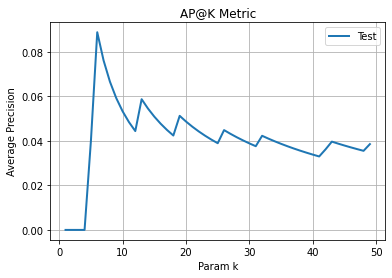

In [ ]:
plot_mapk()

In [ ]:
model_light_fm = LightFM(no_components=120)

In [ ]:
model_light_fm.fit(sparse_ratings,
                    user_features=user_features,
                    item_features=item_features,
                    epochs=40)

In [ ]:
predictions = model_light_fm.predict(test_user_ids,
                            test_item_ids,
                            user_features=user_features,
                            item_features=item_features)

In [ ]:
print(min(predictions), max(predictions))

-4.1070457 13.813693


In [ ]:
sorted_ids = np.argsort(predictions)[::-1]
taken_books = []
for i in range(len(taken_items)):
  book_title = items_info[items_info.book_id==taken_items[i]].Book_title.item()
  taken_books.append(book_title)
pred_books = []
for i in sorted_ids:
  if (predictions[i] > 0):
    pred_books.append(taken_books[i])
len(pred_books)

989

In [ ]:
mapk_metrics = []
for i in range(1, 30, 1):
  prec = mapk([relevant_books], [pred_books], i)
  mapk_metrics.append(prec)

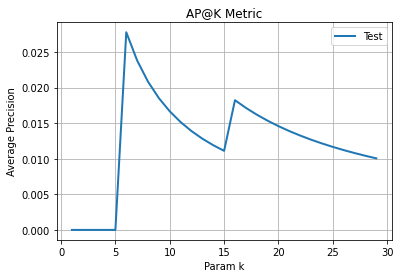

In [ ]:
plot_mapk()

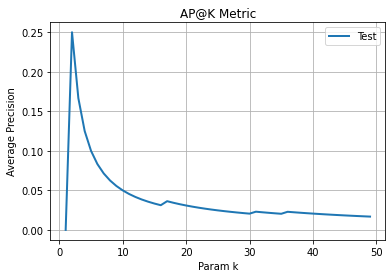

In [ ]:
plot_mapk()

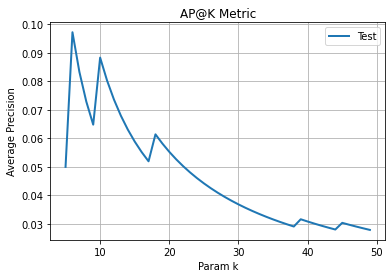

In [ ]:
plot_mapk()